In [1]:
import torch
import numpy as np
import pandas as pd
import wfdb
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import random
import sys
sys.path.append("../src/datasets")
from cardiac_helper import extract_segment_before_alarm


In [2]:
# work done in hylian machine

waveform_summary = pd.read_csv("/scratch/mc-med/data/waveform_summary.csv")
waveform_summary = waveform_summary[waveform_summary['Type'] == 'II']
waveform_summary.head()

,CSN,Type,Segments,Duration
0,99633476,II,1,2204.742
4,99960476,II,4,12818.304
7,99470476,II,2,13918.498
11,99438476,II,2,11579.046
15,99439476,II,3,2853.788


In [3]:
Full_CSN = 99016000 # as an example 
waveform_summary[waveform_summary['CSN'] == Full_CSN]

,CSN,Type,Segments,Duration
58946,99016000,II,2,1166.926


In [4]:
## import computed alarms
alarms_df = pd.read_parquet('../data/sick_time.parquet', engine='pyarrow')
alarms_df.head()

,CSN,Alarm
0,98974916,2288-12-08 10:17:39
1,98975250,2279-10-24 08:40:37
2,98982225,2238-07-19 10:31:15
3,98990360,2242-01-14 19:43:37
4,98995384,2276-05-18 10:59:45


In [5]:
visits_df = pd.read_csv("/scratch/mc-med/data/visits.csv")
visits_df.head()

,MRN,CSN,Visit_no,Visits,Age,Gender,Race,Ethnicity,Means_of_arrival,Triage_Temp,...,Payor_class,Admit_service,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_time,Roomed_time,Dispo_time,Admit_time,Departure_time
0,98880961,98874959,1,1,82,F,White,Non-Hispanic/Non-Latino,EMS,36.2,...,Medicare,Medicine,873.20,S01.21XA,"Laceration of nose, initial encounter",2283-03-02T07:36:59Z,2283-03-02T07:36:59Z,2283-03-02T12:29:59Z,2283-03-02T12:29:59Z,2283-03-02T13:44:59Z
1,99121566,99354408,1,2,59,F,Other,Non-Hispanic/Non-Latino,EMS,36.8,...,NaN,Emergency Medicine,780.97,R41.82,"Altered mental status, unspecified altered men...",2239-08-22T01:13:51Z,2239-08-22T01:16:51Z,2239-08-22T07:20:51Z,2239-08-22T07:20:51Z,2239-08-22T10:45:51Z
2,99121566,99121037,2,2,63,F,Other,Non-Hispanic/Non-Latino,EMS,37.2,...,NaN,Critical Care,"038.9, 785.52, 995.92","A41.9, R65.21",Septic shock (CMS-HCC),2240-03-11T03:06:51Z,2240-03-11T03:43:51Z,2240-03-11T08:31:51Z,2240-03-11T08:31:51Z,2240-03-11T13:37:51Z
3,99608739,99327434,1,2,90,F,White,Non-Hispanic/Non-Latino,Self,NaN,...,Medicare,NaN,729.81,M79.89,Leg swelling,2296-08-31T16:43:05Z,2296-08-31T17:56:05Z,2296-08-31T20:56:05Z,NaN,2296-08-31T21:06:05Z
4,99608739,99502864,2,2,89,F,White,Non-Hispanic/Non-Latino,Self,36.4,...,Medicare,NaN,788.20,R33.9,Urinary retention,2297-06-07T05:08:05Z,2297-06-07T05:59:05Z,2297-06-07T08:55:05Z,NaN,2297-06-07T09:35:05Z


In [6]:
visits_df[visits_df['CSN'] == Full_CSN]

,MRN,CSN,Visit_no,Visits,Age,Gender,Race,Ethnicity,Means_of_arrival,Triage_Temp,...,Payor_class,Admit_service,Dx_ICD9,Dx_ICD10,Dx_name,Arrival_time,Roomed_time,Dispo_time,Admit_time,Departure_time
8085,99911467,99016000,3,3,86,F,White,Non-Hispanic/Non-Latino,EMS,36.4,...,Medicare,NaN,724.2,M54.50,"Acute bilateral low back pain, unspecified whe...",2294-09-18T06:46:47Z,2294-09-18T06:47:47Z,2294-09-18T13:09:47Z,NaN,2294-09-18T15:43:47Z


## Waveform Data -- we use ECG
The data are organized into compressed archives (waveforms_0xx.zip, waveforms_1xx.zip, etc.) based on the last three digits of each Visit ID (CSN). Each ZIP archive extracts to a nested folder structure:

```
    {CSN_suffix}/              # Folder named by last three digits of the CSN
        {Full_CSN}/            # Folder named by the full CSN (visit identifier)
            II/                # ECG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
            Pleth/             # PPG waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
                ...
            Resp/              # Respiration waveform segments
                {Full_CSN}_{segment_number}.dat
                {Full_CSN}_{segment_number}.hea
```

* **.dat and .hea Files**: The waveforms are stored in WFDB (WaveForm DataBase) format. Each segment consists of a header file (.hea) and a binary data file (.dat).
* **Segmenting**: Waveforms may be split into multiple segments due to discontinuities or equipment disconnections.

### Data Linkages
The primary key to link tables is:

* **CSN** (Visit identifier): Uniquely identifies a patient's ED visit. Use CSN to join visits.csv with labs.csv, orders.csv, rads.csv, and numerics.csv.
* **MRN** (Patient identifier): Identifies unique patients and can be used to link meds.csv and pmh.csv to patient-level information (e.g., multiple visits from the same patient).

Note: To respect patient privacy and prevent re-identification, MRN and CSN are randomized and do not map to original patient identifiers.


### Some pre-processing

In [ ]:
########################
# FYI - each has ~50 patient visits, and each visit can have multiple segments
# note that some don't have both .hea and .dat files, which means we have to ignore/discard those
# the following has no alarms
# CSN_suffix = '000' 
# CSN_suffix = '001' 
# CSN_suffix = '002' 


In [30]:
def get_start_end_times(record):
    start_dt = datetime.combine(record.base_date, record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    # print("Date:", record.base_date)
    # print("Start time:", record.base_time)
    # print("End time:", end_dt.time())
    return start_dt, end_dt

In [33]:
waveforms_folder_path = "/scratch/mc-med/waveforms"
CSN_suffixes = sorted([f.name for f in os.scandir(waveforms_folder_path) if f.is_dir()])
# CSN_suffixes = ['000', '001', '002', '003', '004'] 
waveform_type = 'II'

neg_dataset = []
pos_dataset = []
threshold = 500 # upper bound, there will be far less positive examples

all_CSN_so_far = set()
all_MRN_so_far = set()

with tqdm(CSN_suffixes, desc="Processing", dynamic_ncols=True) as pbar:
    for CSN_suffix in pbar:
        records_path = f"{waveforms_folder_path}/{CSN_suffix}/RECORDS"
        with open(records_path, "r") as f:
            lines = f.read().split('\n')    
        segment_paths = [line for line in lines if waveform_type in line]
        visit_ids = torch.tensor([int(segment_path[:8]) for segment_path in segment_paths]).unique()
        alarm_visit_ids = torch.tensor([i.item() for i in visit_ids if i in alarms_df['CSN'].unique()])
    
        for CSN in visit_ids: # Full_CSN is another name for visit_id
            CSN = CSN.item()
            MRN = visits_df[visits_df['CSN'] == CSN].iloc[0]['MRN'].item()
            if CSN not in all_CSN_so_far and MRN not in all_MRN_so_far:
                CSN_segment_paths = [segment_path for segment_path in segment_paths if int(segment_path[:8]) == CSN]
        
                # add a positive example
                if CSN in alarm_visit_ids and len(pos_dataset) < threshold: 
                    alarm_dt = alarms_df[alarms_df['CSN'] == CSN]['Alarm'].iloc[0]
                    # find the segment that contains the alarm
                    for segment_path in segment_paths:
                        record_path = f"{waveforms_folder_path}/{CSN_suffix}/{segment_path}"
                        # print(record_path)
                        record_path_hea = record_path + '.hea'
                        record_path_dat = record_path + '.dat'
                        if os.path.isfile(record_path_hea) and os.path.isfile(record_path_dat):
                            # Read the record
                            record = wfdb.rdrecord(record_path)
                            start_dt, end_dt = get_start_end_times(record)
                            if alarm_dt > start_dt and alarm_dt < end_dt:
                                # print('Alarm')
                                record_dict = {'label': True, 'alarm': alarm_dt, **record.__dict__}
                                # add visit info
                                visit_dict = visits_df[visits_df['CSN'] == CSN].iloc[0].to_dict()
                                record_dict = {**record_dict, **visit_dict}
    
                                # also truncate the endtime? or maybe let's try if the longer version works
                                pos_dataset.append(record_dict)
                                all_CSN_so_far.add(CSN)
                                all_MRN_so_far.add(MRN)
                                break
                
                # or add a negative example
                elif CSN not in alarm_visit_ids and len(neg_dataset) < threshold:
                    # just pick the first segment
                    segment_path = CSN_segment_paths[0]
                    record_path = f"{waveforms_folder_path}/{CSN_suffix}/{segment_path}"
                    # print(record_path)
                    record_path_hea = record_path + '.hea'
                    record_path_dat = record_path + '.dat'
                    if os.path.isfile(record_path_hea) and os.path.isfile(record_path_dat):
                        # Read the record
                        record = wfdb.rdrecord(record_path)
                        # set label to False (i.e. we have a negative example)
                        record_dict = {'label': False, 'alarm': None, **record.__dict__}
                        # add visit info
                        visit_dict = visits_df[visits_df['CSN'] == CSN].iloc[0].to_dict()
                        record_dict = {**record_dict, **visit_dict}
                        neg_dataset.append(record_dict) 
                        all_CSN_so_far.add(CSN)
                        all_MRN_so_far.add(MRN)
        pbar.set_postfix(pos=len(pos_dataset), neg=len(neg_dataset))


Processing: 100%|████████████████████████████████████████| 1000/1000 [09:40<00:00,  1.72it/s, neg=500, pos=279]


In [23]:
len(neg_dataset), len(pos_dataset)

500

In [76]:
train_sz = 400
val_sz = 50
test_sz = 50

# balance the train dataset 
random.shuffle(neg_dataset)
random.shuffle(pos_dataset)
train_dataset = neg_dataset[:train_sz//2] + pos_dataset[:train_sz//2]

r1 = random.randint(1, val_sz)
print(r1)
val_dataset = neg_dataset[train_sz//2:][:val_sz - r1] + pos_dataset[train_sz//2:][:r1]

r2 = random.randint(1, min(len(pos_dataset) - train_sz//2 - r1, 50))
print(r2)
test_dataset = neg_dataset[train_sz//2 + val_sz - r1:][:test_sz - r2] + pos_dataset[train_sz//2 + r1:][:r2]

print(len(train_dataset), len(val_dataset), len(test_dataset))

34
39
400 50 50


In [72]:
def correct_dataset_field_types(dataset, field_type_map):
    """
    Ensures each field in the dataset has consistent types.
    
    Parameters:
    - dataset (List[Dict]): The list of records (your dataset).
    - field_type_map (Dict[str, type]): Mapping of field names to desired type (e.g., {"text": str})
    
    Returns:
    - List[Dict]: Corrected dataset with consistent types.
    """
    corrected = []
    for row in dataset:
        new_row = {}
        for key, value in row.items():
            if key in field_type_map:
                try:
                    new_row[key] = field_type_map[key](value)
                except Exception:
                    new_row[key] = None  # or keep original with: row[key]
            else:
                new_row[key] = value
        corrected.append(new_row)
    return corrected


In [80]:
def safe_convert(example):
    return {k: str(v) if isinstance(v, float) and not isinstance(v, bool) else v for k, v in example.items()}

train_dataset = [safe_convert(ex) for ex in train_dataset]
val_dataset = [safe_convert(ex) for ex in val_dataset]
test_dataset = [safe_convert(ex) for ex in test_dataset]


In [81]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(train_dataset)
val_dataset = Dataset.from_list(val_dataset)
test_dataset = Dataset.from_list(test_dataset)

In [82]:
# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [83]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size', 'MRN', 'CSN', 'Visit_no', 'Visits', 'Age', 'Gender', 'Race', 'Ethnicity', 'Means_of_arrival', 'Triage_Temp', 'Triage_HR', 'Triage_RR', 'Triage_SpO2', 'Triage_SBP', 'Triage_DBP', 'Triage_acuity', 'CC', 'ED_dispo', 'Hours_to_next_visit', 'Dispo_class_next_visit', 'ED_LOS', 'Hosp_LOS', 'DC_dispo', 'Payor_class', 'Admit_service', 'Dx_ICD9', 'Dx_ICD10', 'Dx_name', 'Arrival_time', 'Roomed_time', 'Dispo_time', 'Admit_time', 'Departure_time'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', '

In [84]:
dataset_dict.push_to_hub("BrachioLab/mcmed-cardiac-full")

Uploading the dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BrachioLab/mcmed-cardiac-full/commit/1bfcc57a72f8cf666d424714e0a45c7245d7b640', commit_message='Upload dataset', commit_description='', oid='1bfcc57a72f8cf666d424714e0a45c7245d7b640', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BrachioLab/mcmed-cardiac-full', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BrachioLab/mcmed-cardiac-full'), pr_revision=None, pr_num=None)

## further cleaning (let's make the real mcmed-cardiac dataset that has the correct cutoff times based on alarms)

 - Potential Task: given 5 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - *Shorter Task:* given 2 minutes of ECG data at 100 Hz, predict whether this patient gets cardiac arrest in the next 5 minutes
 - **Chosen Task:** given 2 minutes of ECG data at 500 Hz (in a graph image), predict whether this patient gets cardiac arrest in the next 5 minutes

Also each is given patient age, gender, race and ICU visit reason

--> so we need to save the following

Pipeline:
1. get the alarm time
2. subtract r = 1- 300 sec from it
3. this is your new cutoff time
4. then take the preceding 120 seconds from that

in terms of p_signal data:
1. get new cutoff time data = orig_alarm_time_data_index - r * fs
2. get new start time data = new_cutoff_time_data_index - 120 * fs
   

In [7]:
from datasets import load_dataset

ds = load_dataset("BrachioLab/mcmed-cardiac-full")

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
train_data = ds['train']
record_keys = ['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size']
visit_attrs = visits_df.keys().to_list()

In [9]:
len(train_data[0]['p_signal'])

1593472

In [11]:
train_data[0]['sig_len']

1593472

In [12]:
train_data[0]['init_value']

[-21983]

In [16]:
train_data[0]

{'label': False,
 'alarm': None,
 'record_name': '99966001_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1593472,
 'base_time': datetime.time(14, 0, 24, 873000),
 'base_date': datetime.date(2226, 12, 13),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': [[-0.025036886757654003],
  [-0.020029509406123202],
  [-0.030044264109184805],
  [-0.020029509406123202],
  [-0.030044264109184805],
  [-0.015022132054592402],
  [-0.020029509406123202],
  [-0.030044264109184805],
  [-0.020029509406123202],
  [-0.025036886757654003],
  [-0.030044264109184805],
  [-0.04506639616377721],
  [-0.035051641460715606],
  [-0.04506639616377721],
  [-0.040059018812246404],
  [-0.035051641460715606],
  [-0.030044264109184805],
  [-0.025036886757654003],
  [-0.030044264109184805],
  [-0.025036886757654003],
  [-0.025036886757654003],
  [-0.040059018812246404],
  [-0.040059018812246404],
  [-0.04506639616377721],
  [-0.030044264109184805],
  [-0.04506639616377721],
  [-0.

In [13]:
train_data[0]['p_signal'][0]

[-0.025036886757654003]

In [17]:
duration_sec = 120
max_predict_window_sec = 300

train_segments = []
for i in tqdm(range(len(train_data))):
    example = train_data[i]
    record_dict = {k: v for k, v in example.items() if k in record_keys}
    record_dict['p_signal'] = np.array(record_dict['p_signal']) 
    record = wfdb.Record(**record_dict)

    try:
        segment_record = extract_segment_before_alarm(record, example['alarm'], duration_sec, max_predict_window_sec)
        visit_dict = {k: example[k] for k in visit_attrs if k in example}
        segment = {'label': example['label'], 'alarm': example['alarm'], **segment_record.__dict__, **visit_dict}    
        train_segments.append(segment)
    except Exception as e:
        print(f"Skipping example {i}: {e}")
        continue  

  0%|▏                                                                         | 1/400 [00:02<17:07,  2.58s/it]

252
0.0
120.0


  0%|▎                                                                         | 2/400 [00:06<23:38,  3.56s/it]

266
0.0
120.0


  1%|▌                                                                         | 3/400 [00:10<22:30,  3.40s/it]

283
0.0
120.0


  1%|▋                                                                         | 4/400 [00:11<17:13,  2.61s/it]

221
0.0
120.0


  1%|▉                                                                         | 5/400 [00:13<14:47,  2.25s/it]

209
0.0
120.0


  2%|█                                                                         | 6/400 [00:14<12:15,  1.87s/it]

37
0.0
120.0


  2%|█▎                                                                        | 7/400 [00:14<08:52,  1.36s/it]

150
0.0
120.0


  2%|█▍                                                                        | 8/400 [00:16<09:45,  1.49s/it]

222
0.0
120.0


  2%|█▊                                                                       | 10/400 [00:20<10:40,  1.64s/it]

44
0.0
120.0
205
0.0
120.0


  3%|██                                                                       | 11/400 [00:22<10:32,  1.63s/it]

256
0.0
120.0


  3%|██▏                                                                      | 12/400 [00:25<13:03,  2.02s/it]

277
0.0
120.0


  3%|██▎                                                                      | 13/400 [00:28<16:51,  2.61s/it]

114
0.0
120.0


  4%|██▌                                                                      | 14/400 [00:32<17:53,  2.78s/it]

222
0.0
120.0


  4%|██▋                                                                      | 15/400 [00:37<22:57,  3.58s/it]

106
0.0
120.0


  4%|██▉                                                                      | 16/400 [00:39<19:43,  3.08s/it]

103
0.0
120.0


  4%|███                                                                      | 17/400 [00:52<38:57,  6.10s/it]

163
0.0
120.0


  4%|███▎                                                                     | 18/400 [00:56<33:46,  5.31s/it]

213
0.0
120.0


  5%|███▍                                                                     | 19/400 [01:02<36:03,  5.68s/it]

179
0.0
120.0


  5%|███▋                                                                     | 20/400 [01:04<28:45,  4.54s/it]

48
0.0
120.0


  5%|███▊                                                                     | 21/400 [01:06<23:59,  3.80s/it]

277
0.0
120.0


  6%|████                                                                     | 22/400 [01:22<47:44,  7.58s/it]

243
0.0
120.0


  6%|████▏                                                                    | 23/400 [01:23<33:48,  5.38s/it]

271
0.0
120.0


  6%|████▍                                                                    | 24/400 [01:24<26:09,  4.17s/it]

286
0.0
120.0


  6%|████▌                                                                    | 25/400 [01:29<27:36,  4.42s/it]

110
0.0
120.0


  6%|████▋                                                                    | 26/400 [01:43<45:54,  7.36s/it]

82
0.0
120.0


  7%|████▉                                                                    | 27/400 [01:47<38:29,  6.19s/it]

17
0.0
120.0


  7%|█████                                                                    | 28/400 [01:48<28:24,  4.58s/it]

69
0.0
120.0


  7%|█████▎                                                                   | 29/400 [01:48<21:12,  3.43s/it]

200
0.0
120.0


  8%|█████▍                                                                   | 30/400 [01:53<23:58,  3.89s/it]

223
0.0
120.0


  8%|█████▋                                                                   | 31/400 [01:57<23:24,  3.81s/it]

165
0.0
120.0


  8%|█████▊                                                                   | 32/400 [01:59<20:54,  3.41s/it]

97
0.0
120.0


  8%|██████                                                                   | 33/400 [02:02<19:13,  3.14s/it]

53
0.0
120.0


  8%|██████▏                                                                  | 34/400 [02:11<29:54,  4.90s/it]

64
0.0
120.0


  9%|██████▍                                                                  | 35/400 [02:12<23:07,  3.80s/it]

198
0.0
120.0


  9%|██████▌                                                                  | 36/400 [02:13<18:26,  3.04s/it]

15
0.0
120.0


  9%|██████▊                                                                  | 37/400 [02:14<14:47,  2.44s/it]

103
0.0
120.0


 10%|███████                                                                  | 39/400 [02:19<12:49,  2.13s/it]

25
0.0
120.0
276
0.0
120.0


 10%|███████▎                                                                 | 40/400 [02:24<18:30,  3.08s/it]

6
0.0
120.0


 10%|███████▍                                                                 | 41/400 [02:31<25:06,  4.20s/it]

273
0.0
120.0


 10%|███████▋                                                                 | 42/400 [02:32<19:05,  3.20s/it]

196
0.0
120.0


 11%|███████▊                                                                 | 43/400 [02:46<38:11,  6.42s/it]

182
0.0
120.0


 11%|████████                                                                 | 44/400 [02:52<37:30,  6.32s/it]

183
0.0
120.0


 11%|████████▏                                                                | 45/400 [02:53<27:53,  4.71s/it]

294
0.0
120.0


 12%|████████▍                                                                | 46/400 [02:54<21:50,  3.70s/it]

184
0.0
120.0


 12%|████████▌                                                                | 47/400 [03:07<37:43,  6.41s/it]

189
0.0
120.0


 12%|████████▊                                                                | 48/400 [03:13<37:50,  6.45s/it]

17
0.0
120.0


 12%|████████▉                                                                | 49/400 [03:24<44:47,  7.66s/it]

137
0.0
120.0


 12%|█████████▏                                                               | 50/400 [03:27<37:07,  6.37s/it]

228
0.0
120.0


 13%|█████████▎                                                               | 51/400 [03:29<28:40,  4.93s/it]

168
0.0
120.0


 13%|█████████▍                                                               | 52/400 [03:29<20:30,  3.54s/it]

232
0.0
120.0


 13%|█████████▋                                                               | 53/400 [03:34<23:29,  4.06s/it]

281
0.0
120.0


 14%|█████████▊                                                               | 54/400 [03:38<23:06,  4.01s/it]

267
0.0
120.0


 14%|██████████                                                               | 55/400 [03:44<25:50,  4.50s/it]

180
0.0
120.0


 14%|██████████▏                                                              | 56/400 [03:50<28:52,  5.04s/it]

233
0.0
120.0


 14%|██████████▍                                                              | 57/400 [03:54<26:05,  4.56s/it]

125
0.0
120.0


 14%|██████████▌                                                              | 58/400 [03:54<19:19,  3.39s/it]

50
0.0
120.0


 15%|██████████▊                                                              | 59/400 [03:57<17:20,  3.05s/it]

84
0.0
120.0


 15%|██████████▉                                                              | 60/400 [04:06<28:00,  4.94s/it]

198
0.0
120.0


 15%|███████████▏                                                             | 61/400 [04:08<22:47,  4.03s/it]

41
0.0
120.0


 16%|███████████▎                                                             | 62/400 [04:10<19:07,  3.39s/it]

103
0.0
120.0


 16%|███████████▍                                                             | 63/400 [04:17<25:44,  4.58s/it]

188
0.0
120.0


 16%|███████████▋                                                             | 64/400 [04:18<20:12,  3.61s/it]

66
0.0
120.0


 16%|███████████▊                                                             | 65/400 [04:22<19:24,  3.48s/it]

112
0.0
120.0


 16%|████████████                                                             | 66/400 [04:22<14:53,  2.68s/it]

143
0.0
120.0


 17%|████████████▏                                                            | 67/400 [04:27<17:49,  3.21s/it]

92
0.0
120.0


 17%|████████████▍                                                            | 68/400 [04:32<21:21,  3.86s/it]

233
0.0
120.0


 18%|████████████▊                                                            | 70/400 [04:33<11:51,  2.16s/it]

193
0.0
120.0
187
0.0
120.0


 18%|████████████▉                                                            | 71/400 [04:36<12:16,  2.24s/it]

59
0.0
120.0


 18%|█████████████▏                                                           | 72/400 [04:43<20:23,  3.73s/it]

143
0.0
120.0


 18%|█████████████▎                                                           | 73/400 [04:45<17:57,  3.29s/it]

99
0.0
120.0


 18%|█████████████▌                                                           | 74/400 [04:46<13:43,  2.53s/it]

289
0.0
120.0


 19%|█████████████▋                                                           | 75/400 [04:50<15:34,  2.88s/it]

76
0.0
120.0


 19%|█████████████▊                                                           | 76/400 [04:51<12:42,  2.35s/it]

127
0.0
120.0


 19%|██████████████                                                           | 77/400 [05:01<24:17,  4.51s/it]

80
0.0
120.0


 20%|██████████████▏                                                          | 78/400 [05:05<23:55,  4.46s/it]

187
0.0
120.0


 20%|██████████████▍                                                          | 79/400 [05:11<26:50,  5.02s/it]

121
0.0
120.0


 20%|██████████████▌                                                          | 80/400 [05:12<20:29,  3.84s/it]

152
0.0
120.0


 20%|██████████████▊                                                          | 81/400 [05:25<35:03,  6.59s/it]

59
0.0
120.0


 20%|██████████████▉                                                          | 82/400 [05:34<37:38,  7.10s/it]

59
0.0
120.0


 21%|███████████████▏                                                         | 83/400 [05:37<31:52,  6.03s/it]

120
0.0
120.0


 21%|███████████████▎                                                         | 84/400 [05:38<23:58,  4.55s/it]

219
0.0
120.0


 21%|███████████████▌                                                         | 85/400 [05:42<22:59,  4.38s/it]

221
0.0
120.0


 22%|███████████████▋                                                         | 86/400 [05:45<19:45,  3.77s/it]

37
0.0
120.0


 22%|███████████████▉                                                         | 87/400 [05:47<17:42,  3.39s/it]

278
0.0
120.0


 22%|████████████████                                                         | 88/400 [06:00<32:02,  6.16s/it]

158
0.0
120.0


 22%|████████████████▏                                                        | 89/400 [06:04<28:54,  5.58s/it]

247
0.0
120.0


 22%|████████████████▍                                                        | 90/400 [06:12<32:51,  6.36s/it]

102
0.0
120.0


 23%|████████████████▌                                                        | 91/400 [06:13<24:42,  4.80s/it]

48
0.0
120.0


 23%|████████████████▊                                                        | 92/400 [06:16<21:16,  4.15s/it]

161
0.0
120.0


 23%|████████████████▉                                                        | 93/400 [06:25<28:22,  5.54s/it]

228
0.0
120.0


 24%|█████████████████▏                                                       | 94/400 [06:27<23:26,  4.59s/it]

215
0.0
120.0


 24%|█████████████████▎                                                       | 95/400 [06:36<29:44,  5.85s/it]

12
0.0
120.0


 24%|█████████████████▌                                                       | 96/400 [06:37<23:10,  4.58s/it]

65
0.0
120.0


 24%|█████████████████▋                                                       | 97/400 [06:42<23:05,  4.57s/it]

228
0.0
120.0


 24%|█████████████████▉                                                       | 98/400 [06:50<28:47,  5.72s/it]

193
0.0
120.0


 25%|██████████████████                                                       | 99/400 [06:52<23:11,  4.62s/it]

228
0.0
120.0


 25%|██████████████████                                                      | 100/400 [06:53<16:32,  3.31s/it]

123
0.0
120.0


 25%|██████████████████▏                                                     | 101/400 [06:53<12:34,  2.52s/it]

253
0.0
120.0


 26%|██████████████████▎                                                     | 102/400 [07:00<18:53,  3.80s/it]

189
0.0
120.0


 26%|██████████████████▌                                                     | 103/400 [07:01<14:33,  2.94s/it]

36
0.0
120.0


 26%|██████████████████▋                                                     | 104/400 [07:11<25:16,  5.12s/it]

151
0.0
120.0


 26%|██████████████████▉                                                     | 105/400 [07:17<25:21,  5.16s/it]

170
0.0
120.0


 26%|███████████████████                                                     | 106/400 [07:30<37:01,  7.56s/it]

101
0.0
120.0


 27%|███████████████████▎                                                    | 107/400 [07:33<30:48,  6.31s/it]

131
0.0
120.0


 27%|███████████████████▍                                                    | 108/400 [07:35<24:03,  4.94s/it]

110
0.0
120.0


 28%|███████████████████▊                                                    | 110/400 [07:36<13:13,  2.74s/it]

279
0.0
120.0
289
0.0
120.0


 28%|███████████████████▉                                                    | 111/400 [07:45<21:05,  4.38s/it]

202
0.0
120.0


 28%|████████████████████▏                                                   | 112/400 [07:50<22:44,  4.74s/it]

118
0.0
120.0


 28%|████████████████████▎                                                   | 113/400 [07:53<19:24,  4.06s/it]

43
0.0
120.0


 28%|████████████████████▌                                                   | 114/400 [07:58<21:21,  4.48s/it]

113
0.0
120.0


 29%|████████████████████▋                                                   | 115/400 [07:58<15:29,  3.26s/it]

199
0.0
120.0


 29%|████████████████████▉                                                   | 116/400 [08:00<13:15,  2.80s/it]

116
0.0
120.0


 29%|█████████████████████                                                   | 117/400 [08:04<15:03,  3.19s/it]

60
0.0
120.0


 30%|█████████████████████▏                                                  | 118/400 [08:05<11:17,  2.40s/it]

97
0.0
120.0


 30%|█████████████████████▍                                                  | 119/400 [08:06<09:44,  2.08s/it]

246
0.0
120.0


 30%|█████████████████████▌                                                  | 120/400 [08:07<07:47,  1.67s/it]

194
0.0
120.0


 30%|█████████████████████▊                                                  | 121/400 [08:10<09:56,  2.14s/it]

160
0.0
120.0


 30%|█████████████████████▉                                                  | 122/400 [08:17<16:56,  3.66s/it]

197
0.0
120.0


 31%|██████████████████████▏                                                 | 123/400 [08:23<19:04,  4.13s/it]

53
0.0
120.0


 31%|██████████████████████▎                                                 | 124/400 [08:31<24:29,  5.32s/it]

137
0.0
120.0


 31%|██████████████████████▌                                                 | 125/400 [08:37<26:23,  5.76s/it]

2
0.0
120.0


 32%|██████████████████████▋                                                 | 126/400 [08:39<20:15,  4.43s/it]

128
0.0
120.0


 32%|██████████████████████▊                                                 | 127/400 [08:39<14:51,  3.26s/it]

247
0.0
120.0


 32%|███████████████████████                                                 | 128/400 [08:40<11:54,  2.63s/it]

6
0.0
120.0


 32%|███████████████████████▏                                                | 129/400 [08:41<08:41,  1.92s/it]

212
0.0
120.0


 32%|███████████████████████▍                                                | 130/400 [08:47<13:56,  3.10s/it]

124
0.0
120.0


 33%|███████████████████████▌                                                | 131/400 [08:47<10:44,  2.40s/it]

166
0.0
120.0


 33%|███████████████████████▊                                                | 132/400 [08:50<10:46,  2.41s/it]

177
0.0
120.0


 33%|███████████████████████▉                                                | 133/400 [08:51<08:55,  2.01s/it]

63
0.0
120.0


 34%|████████████████████████                                                | 134/400 [08:53<09:38,  2.18s/it]

205
0.0
120.0


 34%|████████████████████████▎                                               | 135/400 [08:58<12:38,  2.86s/it]

150
0.0
120.0


 34%|████████████████████████▍                                               | 136/400 [09:03<15:39,  3.56s/it]

189
0.0
120.0


 34%|████████████████████████▋                                               | 137/400 [09:08<17:44,  4.05s/it]

193
0.0
120.0


 34%|████████████████████████▊                                               | 138/400 [09:09<13:03,  2.99s/it]

273
0.0
120.0


 35%|█████████████████████████                                               | 139/400 [09:10<10:29,  2.41s/it]

235
0.0
120.0


 35%|█████████████████████████▏                                              | 140/400 [09:13<10:52,  2.51s/it]

65
0.0
120.0


 35%|█████████████████████████▍                                              | 141/400 [09:15<11:06,  2.57s/it]

80
0.0
120.0


 36%|█████████████████████████▌                                              | 142/400 [09:17<10:33,  2.45s/it]

138
0.0
120.0


 36%|█████████████████████████▋                                              | 143/400 [09:20<10:49,  2.53s/it]

27
0.0
120.0
197
0.0
120.0


 36%|██████████████████████████▎                                             | 146/400 [09:22<05:43,  1.35s/it]

221
0.0
120.0
235
0.0
120.0


 37%|██████████████████████████▍                                             | 147/400 [09:25<07:18,  1.73s/it]

257
0.0
120.0


 37%|██████████████████████████▋                                             | 148/400 [09:26<06:08,  1.46s/it]

102
0.0
120.0


 37%|██████████████████████████▊                                             | 149/400 [09:28<06:46,  1.62s/it]

102
0.0
120.0


 38%|███████████████████████████                                             | 150/400 [09:29<06:12,  1.49s/it]

157
0.0
120.0


 38%|███████████████████████████▏                                            | 151/400 [09:33<09:20,  2.25s/it]

227
0.0
120.0


 38%|███████████████████████████▎                                            | 152/400 [09:36<10:28,  2.53s/it]

97
0.0
120.0


 38%|███████████████████████████▌                                            | 153/400 [09:43<15:53,  3.86s/it]

4
0.0
120.0


 38%|███████████████████████████▋                                            | 154/400 [09:46<14:17,  3.49s/it]

156
0.0
120.0


 39%|███████████████████████████▉                                            | 155/400 [09:46<10:19,  2.53s/it]

96
0.0
120.0


 39%|████████████████████████████                                            | 156/400 [09:47<08:15,  2.03s/it]

117
0.0
120.0


 39%|████████████████████████████▎                                           | 157/400 [09:49<07:55,  1.96s/it]

235
0.0
120.0


 40%|████████████████████████████▍                                           | 158/400 [09:50<07:04,  1.75s/it]

210
0.0
120.0


 40%|████████████████████████████▌                                           | 159/400 [09:54<09:25,  2.35s/it]

144
0.0
120.0


 40%|████████████████████████████▊                                           | 160/400 [10:02<16:29,  4.12s/it]

246
0.0
120.0


 40%|████████████████████████████▉                                           | 161/400 [10:08<18:31,  4.65s/it]

8
0.0
120.0


 40%|█████████████████████████████▏                                          | 162/400 [10:17<24:18,  6.13s/it]

132
0.0
120.0


 41%|█████████████████████████████▎                                          | 163/400 [10:22<23:02,  5.83s/it]

243
0.0
120.0


 41%|█████████████████████████████▌                                          | 164/400 [10:29<23:31,  5.98s/it]

202
0.0
120.0


 41%|█████████████████████████████▋                                          | 165/400 [10:33<21:36,  5.51s/it]

60
0.0
120.0


 42%|█████████████████████████████▉                                          | 166/400 [10:38<20:06,  5.16s/it]

66
0.0
120.0


 42%|██████████████████████████████                                          | 167/400 [10:38<14:56,  3.85s/it]

217
0.0
120.0


 42%|██████████████████████████████▏                                         | 168/400 [10:40<12:02,  3.12s/it]

238
0.0
120.0


 42%|██████████████████████████████▍                                         | 169/400 [10:41<09:57,  2.58s/it]

162
0.0
120.0


 42%|██████████████████████████████▌                                         | 170/400 [10:43<08:35,  2.24s/it]

87
0.0
120.0


 43%|██████████████████████████████▊                                         | 171/400 [10:43<06:25,  1.68s/it]

123
0.0
120.0


 43%|███████████████████████████████▏                                        | 173/400 [10:43<03:26,  1.10it/s]

45
0.0
120.0
112
0.0
120.0


 44%|███████████████████████████████▎                                        | 174/400 [10:57<17:35,  4.67s/it]

33
0.0
120.0


 44%|███████████████████████████████▌                                        | 175/400 [11:00<16:14,  4.33s/it]

103
0.0
120.0


 44%|███████████████████████████████▋                                        | 176/400 [11:03<14:11,  3.80s/it]

95
0.0
120.0


 44%|███████████████████████████████▊                                        | 177/400 [11:07<15:04,  4.06s/it]

73
0.0
120.0


 44%|████████████████████████████████                                        | 178/400 [11:15<19:10,  5.18s/it]

142
0.0
120.0


 45%|████████████████████████████████▏                                       | 179/400 [11:23<22:03,  5.99s/it]

212
0.0
120.0


 45%|████████████████████████████████▍                                       | 180/400 [11:26<18:24,  5.02s/it]

194
0.0
120.0


 45%|████████████████████████████████▌                                       | 181/400 [11:32<19:06,  5.24s/it]

124
0.0
120.0


 46%|████████████████████████████████▊                                       | 182/400 [11:34<15:34,  4.29s/it]

205
0.0
120.0


 46%|████████████████████████████████▉                                       | 183/400 [11:38<15:15,  4.22s/it]

60
0.0
120.0


 46%|█████████████████████████████████                                       | 184/400 [11:40<12:52,  3.58s/it]

65
0.0
120.0


 46%|█████████████████████████████████▎                                      | 185/400 [11:41<10:07,  2.82s/it]

37
0.0
120.0


 46%|█████████████████████████████████▍                                      | 186/400 [11:41<07:29,  2.10s/it]

83
0.0
120.0


 47%|█████████████████████████████████▋                                      | 187/400 [11:42<05:51,  1.65s/it]

82
0.0
120.0


 47%|█████████████████████████████████▊                                      | 188/400 [11:46<08:26,  2.39s/it]

105
0.0
120.0


 47%|██████████████████████████████████                                      | 189/400 [11:47<06:45,  1.92s/it]

170
0.0
120.0


 48%|██████████████████████████████████▏                                     | 190/400 [11:47<05:05,  1.45s/it]

111
0.0
120.0


 48%|██████████████████████████████████▍                                     | 191/400 [11:53<10:01,  2.88s/it]

244
0.0
120.0


 48%|██████████████████████████████████▋                                     | 193/400 [11:55<06:15,  1.82s/it]

241
0.0
120.0
286
0.0
120.0


 48%|██████████████████████████████████▉                                     | 194/400 [12:02<10:53,  3.17s/it]

68
0.0
120.0


 49%|███████████████████████████████████                                     | 195/400 [12:02<07:49,  2.29s/it]

16
0.0
120.0


 49%|███████████████████████████████████▎                                    | 196/400 [12:06<09:41,  2.85s/it]

115
0.0
120.0


 49%|███████████████████████████████████▍                                    | 197/400 [12:08<08:40,  2.56s/it]

255
0.0
120.0


 50%|███████████████████████████████████▋                                    | 198/400 [12:10<07:50,  2.33s/it]

238
0.0
120.0


 50%|███████████████████████████████████▊                                    | 199/400 [12:12<07:53,  2.36s/it]

122
0.0
120.0


 50%|████████████████████████████████████                                    | 200/400 [12:18<11:48,  3.54s/it]

20
0.0
120.0


 50%|████████████████████████████████████▏                                   | 201/400 [12:19<08:59,  2.71s/it]

155
2243-12-15 23:58:49.662999 2243-12-16 00:15:48.280999
2243-12-16 00:02:02
2243-12-15 23:57:27 2243-12-15 23:59:27
Skipping example 200: 


 50%|████████████████████████████████████▎                                   | 202/400 [12:20<06:55,  2.10s/it]

285
2209-02-26 18:04:53.428000 2209-02-26 18:21:09.236000
2209-02-26 18:14:31
2209-02-26 18:07:46 2209-02-26 18:09:46
172.572
120.0


 51%|████████████████████████████████████▌                                   | 203/400 [12:20<05:21,  1.63s/it]

27
2271-07-21 12:54:18.443001 2271-07-21 13:07:08.863001
2271-07-21 13:02:56
2271-07-21 13:00:29 2271-07-21 13:02:29
370.556999
120.0


 51%|████████████████████████████████████▋                                   | 204/400 [12:21<04:36,  1.41s/it]

122
2243-09-01 03:00:14.009000 2243-09-01 03:12:45.561000
2243-09-01 03:01:14
2243-09-01 02:57:12 2243-09-01 02:59:12
Skipping example 203: 


 51%|████████████████████████████████████▉                                   | 205/400 [12:25<06:22,  1.96s/it]

139
2255-08-12 18:16:30.223000 2255-08-12 19:26:24.621000
2255-08-12 18:21:23
2255-08-12 18:17:04 2255-08-12 18:19:04
33.777
120.0


 52%|█████████████████████████████████████                                   | 206/400 [12:25<04:40,  1.44s/it]

216
2243-10-08 23:38:06.977999 2243-10-08 23:42:55.869999
2243-10-08 23:41:21
2243-10-08 23:35:45 2243-10-08 23:37:45
Skipping example 205: 


 52%|█████████████████████████████████████▎                                  | 207/400 [12:36<14:22,  4.47s/it]

240
2258-06-10 10:03:56.852001 2258-06-10 13:41:03.286001
2258-06-10 13:35:28
2258-06-10 13:29:28 2258-06-10 13:31:28
12331.147999
120.0


 52%|█████████████████████████████████████▍                                  | 208/400 [12:45<18:44,  5.86s/it]

162
2207-07-07 22:19:24.809999 2207-07-08 01:11:28.917999
2207-07-08 01:03:12
2207-07-08 00:58:30 2207-07-08 01:00:30
9545.190001
120.0


 52%|█████████████████████████████████████▌                                  | 209/400 [12:53<20:12,  6.35s/it]

128
2201-12-03 02:36:46.464000 2201-12-03 05:16:03.352000
2201-12-03 02:38:53
2201-12-03 02:34:45 2201-12-03 02:36:45
Skipping example 208: 


 52%|█████████████████████████████████████▊                                  | 210/400 [13:06<26:24,  8.34s/it]

168
2264-03-17 17:57:30.822999 2264-03-17 22:06:55.120999
2264-03-17 18:48:16
2264-03-17 18:43:28 2264-03-17 18:45:28
2757.177001
120.0


 53%|█████████████████████████████████████▉                                  | 211/400 [13:10<22:23,  7.11s/it]

208
2298-05-07 08:26:15.857999 2298-05-07 09:43:40.569999
2298-05-07 08:34:04
2298-05-07 08:28:36 2298-05-07 08:30:36
140.142001
120.0


 53%|██████████████████████████████████████▏                                 | 212/400 [13:11<16:50,  5.37s/it]

250
2218-09-24 16:24:14.880001 2218-09-24 16:54:46.196001
2218-09-24 16:26:06
2218-09-24 16:19:56 2218-09-24 16:21:56
Skipping example 211: 
105
2299-01-19 01:03:49.760999 2299-01-19 01:05:15.558999
2299-01-19 01:04:01
2299-01-19 01:00:16 2299-01-19 01:02:16
Skipping example 212: 


 54%|██████████████████████████████████████▌                                 | 214/400 [13:13<10:00,  3.23s/it]

182
2222-04-08 01:37:41.562000 2222-04-08 02:12:00.606000
2222-04-08 01:38:41
2222-04-08 01:33:39 2222-04-08 01:35:39
Skipping example 213: 


 54%|██████████████████████████████████████▋                                 | 215/400 [13:17<10:42,  3.47s/it]

128
2290-09-28 23:04:16.466001 2290-09-29 00:24:56.316001
2290-09-28 23:04:27
2290-09-28 23:00:19 2290-09-28 23:02:19
Skipping example 214: 


 54%|██████████████████████████████████████▉                                 | 216/400 [13:19<09:09,  2.99s/it]

10
2269-12-27 14:48:10.866999 2269-12-27 15:14:29.198999
2269-12-27 14:48:57
2269-12-27 14:46:47 2269-12-27 14:48:47
Skipping example 215: 
68
2254-06-14 07:49:40.600999 2254-06-14 07:49:57.574999
2254-06-14 07:49:56
2254-06-14 07:46:48 2254-06-14 07:48:48
Skipping example 216: 


 55%|███████████████████████████████████████▏                                | 218/400 [13:24<08:45,  2.89s/it]

161
2282-04-15 04:44:49.238000 2282-04-15 06:37:44.026000
2282-04-15 04:45:37
2282-04-15 04:40:56 2282-04-15 04:42:56
Skipping example 217: 


 55%|███████████████████████████████████████▍                                | 219/400 [13:32<11:56,  3.96s/it]

268
2254-04-09 10:27:43.185000 2254-04-09 12:53:22.633000
2254-04-09 10:54:30
2254-04-09 10:48:02 2254-04-09 10:50:02
1218.815
120.0


 55%|███████████████████████████████████████▌                                | 220/400 [13:39<13:58,  4.66s/it]

177
2223-02-09 18:08:42.324000 2223-02-09 20:17:02.328000
2223-02-09 18:09:09
2223-02-09 18:04:12 2223-02-09 18:06:12
Skipping example 219: 


 55%|███████████████████████████████████████▊                                | 221/400 [13:46<16:17,  5.46s/it]

278
2241-01-18 03:16:00.274000 2241-01-18 05:43:59.186000
2241-01-18 03:39:15
2241-01-18 03:32:37 2241-01-18 03:34:37
996.726
120.0


 56%|███████████████████████████████████████▉                                | 222/400 [13:47<12:40,  4.27s/it]

262
2292-04-11 20:38:18.974000 2292-04-11 21:02:05.100000
2292-04-11 20:46:10
2292-04-11 20:39:48 2292-04-11 20:41:48
89.026
120.0


 56%|████████████████████████████████████████▏                               | 223/400 [13:49<10:20,  3.51s/it]

142
2299-01-13 01:01:37.243001 2299-01-13 01:29:10.283001
2299-01-13 01:12:00
2299-01-13 01:07:38 2299-01-13 01:09:38
360.756999
120.0


 56%|████████████████████████████████████████▎                               | 224/400 [13:54<11:14,  3.83s/it]

65
2277-02-19 20:45:12.168999 2277-02-19 22:14:20.948999
2277-02-19 22:07:04
2277-02-19 22:03:59 2277-02-19 22:05:59
4726.831001
120.0


 56%|████████████████████████████████████████▌                               | 225/400 [13:55<09:11,  3.15s/it]

26
2248-12-16 14:41:21.313999 2248-12-16 15:16:03.483999
2248-12-16 14:57:59
2248-12-16 14:55:33 2248-12-16 14:57:33
851.686001
120.0


 56%|████████████████████████████████████████▋                               | 226/400 [13:58<08:56,  3.08s/it]

52
2232-01-28 00:39:24.123999 2232-01-28 01:40:19.077999
2232-01-28 00:47:26
2232-01-28 00:44:34 2232-01-28 00:46:34
309.876001
120.0


 57%|████████████████████████████████████████▊                               | 227/400 [14:00<08:09,  2.83s/it]

62
2269-11-07 06:33:52.016999 2269-11-07 07:16:07.458999
2269-11-07 06:34:52
2269-11-07 06:31:50 2269-11-07 06:33:50
Skipping example 226: 


 57%|█████████████████████████████████████████                               | 228/400 [14:02<07:25,  2.59s/it]

54
2280-06-06 07:31:20.778000 2280-06-06 08:11:19.304000
2280-06-06 07:45:02
2280-06-06 07:42:08 2280-06-06 07:44:08
647.222
120.0


 57%|█████████████████████████████████████████▏                              | 229/400 [14:06<08:06,  2.84s/it]

108
2200-10-29 18:19:43.187000 2200-10-29 19:20:54.693000
2200-10-29 18:44:03
2200-10-29 18:40:15 2200-10-29 18:42:15
1231.813
120.0


 57%|█████████████████████████████████████████▍                              | 230/400 [14:15<13:20,  4.71s/it]

247
2238-12-20 19:02:19.547000 2238-12-20 21:55:58.377000
2238-12-20 19:17:35
2238-12-20 19:11:28 2238-12-20 19:13:28
548.453
120.0


 58%|█████████████████████████████████████████▌                              | 231/400 [14:16<10:19,  3.67s/it]

226
2220-05-07 18:00:07.009999 2220-05-07 18:27:18.537999
2220-05-07 18:01:07
2220-05-07 17:55:21 2220-05-07 17:57:21
Skipping example 230: 
235
2220-05-08 12:53:58.271000 2220-05-08 12:58:28.489000
2220-05-08 12:54:43
2220-05-08 12:48:48 2220-05-08 12:50:48
Skipping example 231: 


 58%|█████████████████████████████████████████▉                              | 233/400 [14:18<06:25,  2.31s/it]

12
2275-06-17 01:17:10.199999 2275-06-17 01:56:05.213999
2275-06-17 01:24:43
2275-06-17 01:22:31 2275-06-17 01:24:31
320.800001
120.0


 58%|██████████████████████████████████████████                              | 234/400 [14:18<04:42,  1.70s/it]

113
2256-11-30 21:35:52.009999 2256-11-30 21:42:11.989999
2256-11-30 21:36:52
2256-11-30 21:32:59 2256-11-30 21:34:59
Skipping example 233: 


 59%|██████████████████████████████████████████▎                             | 235/400 [14:22<06:21,  2.31s/it]

62
2300-10-28 19:16:56.638001 2300-10-28 20:29:32.380001
2300-10-28 19:58:32
2300-10-28 19:55:30 2300-10-28 19:57:30
2313.361999
120.0


 59%|██████████████████████████████████████████▍                             | 236/400 [14:26<07:46,  2.85s/it]

153
2253-06-12 03:52:27.002999 2253-06-12 05:03:56.764999
2253-06-12 04:53:27
2253-06-12 04:48:54 2253-06-12 04:50:54
3386.997001
120.0


 59%|██████████████████████████████████████████▋                             | 237/400 [14:29<08:08,  3.00s/it]

135
2202-05-05 05:55:22.454000 2202-05-05 07:02:16.928000
2202-05-05 06:01:15
2202-05-05 05:57:00 2202-05-05 05:59:00
97.546
120.0


 60%|██████████████████████████████████████████▊                             | 238/400 [14:36<11:01,  4.08s/it]

199
2288-01-20 20:55:25.014000 2288-01-20 23:04:21.356000
2288-01-20 21:02:25
2288-01-20 20:57:06 2288-01-20 20:59:06
100.986
120.0


 60%|███████████████████████████████████████████                             | 239/400 [14:46<16:06,  6.01s/it]

192
2245-02-05 08:06:57.520000 2245-02-05 11:40:56.742000
2245-02-05 08:25:00
2245-02-05 08:19:48 2245-02-05 08:21:48
770.48
120.0


 60%|███████████████████████████████████████████▏                            | 240/400 [14:50<14:00,  5.25s/it]

193
2252-02-05 15:26:03.711000 2252-02-05 16:27:40.245000
2252-02-05 15:27:35
2252-02-05 15:22:22 2252-02-05 15:24:22
Skipping example 239: 


 60%|███████████████████████████████████████████▍                            | 241/400 [14:54<13:03,  4.93s/it]

187
2268-04-29 22:12:34.297001 2268-04-29 23:40:59.539001
2268-04-29 23:12:12
2268-04-29 23:07:05 2268-04-29 23:09:05
3270.702999
120.0


 60%|███████████████████████████████████████████▌                            | 242/400 [15:12<23:38,  8.98s/it]

150
2223-01-12 18:37:48.623000 2223-01-13 00:34:06.103000
2223-01-12 18:38:06
2223-01-12 18:33:36 2223-01-12 18:35:36
Skipping example 241: 


 61%|███████████████████████████████████████████▋                            | 243/400 [15:20<22:06,  8.45s/it]

193
2298-01-24 14:59:01.782999 2298-01-24 17:16:52.652999
2298-01-24 17:07:46
2298-01-24 17:02:33 2298-01-24 17:04:33
7411.217001
120.0


 61%|███████████████████████████████████████████▉                            | 244/400 [15:21<16:52,  6.49s/it]

20
2206-05-24 14:20:28.383000 2206-05-24 15:04:06.081000
2206-05-24 14:29:37
2206-05-24 14:27:17 2206-05-24 14:29:17
408.617
120.0


 61%|████████████████████████████████████████████                            | 245/400 [15:27<16:15,  6.29s/it]

199
2279-02-26 22:29:41.323999 2279-02-27 00:38:01.327999
2279-02-26 22:30:08
2279-02-26 22:24:49 2279-02-26 22:26:49
Skipping example 244: 


 62%|████████████████████████████████████████████▎                           | 246/400 [15:28<11:52,  4.63s/it]

88
2225-03-31 12:00:13.772000 2225-03-31 12:16:06.766000
2225-03-31 12:08:57
2225-03-31 12:05:29 2225-03-31 12:07:29
315.228
120.0


 62%|████████████████████████████████████████████▍                           | 247/400 [15:34<12:35,  4.94s/it]

113
2270-11-30 01:22:22.011999 2270-11-30 03:09:21.995999
2270-11-30 01:23:22
2270-11-30 01:19:29 2270-11-30 01:21:29
Skipping example 246: 


 62%|████████████████████████████████████████████▋                           | 248/400 [15:41<14:27,  5.71s/it]

160
2267-02-22 10:32:03.283001 2267-02-22 13:02:22.981001
2267-02-22 10:32:25
2267-02-22 10:27:45 2267-02-22 10:29:45
Skipping example 247: 


 62%|████████████████████████████████████████████▊                           | 249/400 [15:42<10:20,  4.11s/it]

247
2295-09-04 05:32:22.546999 2295-09-04 05:38:54.666999
2295-09-04 05:36:53
2295-09-04 05:30:46 2295-09-04 05:32:46
Skipping example 248: 


 62%|█████████████████████████████████████████████                           | 250/400 [15:43<08:10,  3.27s/it]

277
2230-05-31 00:04:24.510000 2230-05-31 00:27:28.936000
2230-05-31 00:20:36
2230-05-31 00:13:59 2230-05-31 00:15:59
574.49
120.0


 63%|█████████████████████████████████████████████▏                          | 251/400 [15:44<06:18,  2.54s/it]

19
2274-07-11 16:45:42.086001 2274-07-11 17:05:54.014001
2274-07-11 16:51:00
2274-07-11 16:48:41 2274-07-11 16:50:41
178.913999
120.0


 63%|█████████████████████████████████████████████▎                          | 252/400 [15:44<04:47,  1.94s/it]

202
2216-04-22 08:17:11.782001 2216-04-22 08:30:07.030001
2216-04-22 08:28:02
2216-04-22 08:22:40 2216-04-22 08:24:40
328.217999
120.0


 64%|█████████████████████████████████████████████▋                          | 254/400 [15:52<06:26,  2.64s/it]

159
2206-09-08 08:19:28.204000 2206-09-08 10:47:41.106000
2206-09-08 08:32:25
2206-09-08 08:27:46 2206-09-08 08:29:46
497.796
120.0
299
2293-11-03 11:57:46.761000 2293-11-03 11:59:06.201000
2293-11-03 11:57:56
2293-11-03 11:50:57 2293-11-03 11:52:57
Skipping example 253: 


 64%|█████████████████████████████████████████████▉                          | 255/400 [16:15<20:46,  8.60s/it]

264
2290-12-04 09:02:55.114999 2290-12-04 16:32:02.226999
2290-12-04 09:32:41
2290-12-04 09:26:17 2290-12-04 09:28:17
1401.885001
120.0


 64%|██████████████████████████████████████████████                          | 256/400 [16:17<16:02,  6.68s/it]

50
2254-10-25 20:15:31.221000 2254-10-25 21:00:49.943000
2254-10-25 20:15:49
2254-10-25 20:12:59 2254-10-25 20:14:59
Skipping example 255: 


 64%|██████████████████████████████████████████████▎                         | 257/400 [16:21<14:05,  5.91s/it]

74
2267-04-21 15:15:46.503001 2267-04-21 16:33:32.895001
2267-04-21 16:28:23
2267-04-21 16:25:09 2267-04-21 16:27:09
4162.496999
120.0


 65%|██████████████████████████████████████████████▌                         | 259/400 [16:27<09:58,  4.25s/it]

246
2242-04-05 21:26:51.093001 2242-04-05 23:27:01.305001
2242-04-05 21:42:35
2242-04-05 21:36:29 2242-04-05 21:38:29
577.906999
120.0
202
2259-10-26 14:52:38.013000 2259-10-26 14:54:38.123000
2259-10-26 14:53:38
2259-10-26 14:48:16 2259-10-26 14:50:16
Skipping example 258: 


 65%|██████████████████████████████████████████████▊                         | 260/400 [16:38<14:13,  6.09s/it]

271
2257-04-25 22:23:31.396001 2257-04-26 01:52:08.918001
2257-04-25 22:24:21
2257-04-25 22:17:50 2257-04-25 22:19:50
Skipping example 259: 


 65%|██████████████████████████████████████████████▉                         | 261/400 [16:42<12:51,  5.55s/it]

50
2251-07-02 07:26:03.606999 2251-07-02 08:47:27.518999
2251-07-02 07:42:50
2251-07-02 07:40:00 2251-07-02 07:42:00
836.393001
120.0


 66%|███████████████████████████████████████████████▏                        | 262/400 [16:44<10:17,  4.47s/it]

66
2277-02-10 14:16:14.041000 2277-02-10 15:03:39.743000
2277-02-10 14:16:27
2277-02-10 14:13:21 2277-02-10 14:15:21
Skipping example 261: 


 66%|███████████████████████████████████████████████▎                        | 263/400 [16:47<08:53,  3.89s/it]

108
2297-09-17 06:11:50.729001 2297-09-17 07:03:28.727001
2297-09-17 06:12:34
2297-09-17 06:08:46 2297-09-17 06:10:46
Skipping example 262: 


 66%|███████████████████████████████████████████████▌                        | 264/400 [16:48<07:11,  3.18s/it]

284
2219-08-10 16:56:37.788000 2219-08-10 17:22:48.798000
2219-08-10 16:57:03
2219-08-10 16:50:19 2219-08-10 16:52:19
Skipping example 263: 


 66%|███████████████████████████████████████████████▋                        | 265/400 [16:53<08:31,  3.79s/it]

195
2201-08-29 09:36:11.617000 2201-08-29 11:23:38.787000
2201-08-29 09:39:39
2201-08-29 09:34:24 2201-08-29 09:36:24
Skipping example 264: 


 66%|███████████████████████████████████████████████▉                        | 266/400 [16:56<07:43,  3.46s/it]

19
2245-09-06 01:42:51.728999 2245-09-06 02:33:59.488999
2245-09-06 01:53:27
2245-09-06 01:51:08 2245-09-06 01:53:08
496.271001
120.0


 67%|████████████████████████████████████████████████                        | 267/400 [16:57<06:14,  2.82s/it]

208
2218-10-22 16:57:44.652000 2218-10-22 17:18:07.252000
2218-10-22 17:01:02
2218-10-22 16:55:34 2218-10-22 16:57:34
Skipping example 266: 


 67%|████████████████████████████████████████████████▏                       | 268/400 [17:00<06:00,  2.73s/it]

37
2269-06-10 23:32:22.513999 2269-06-11 00:25:15.371999
2269-06-10 23:32:41
2269-06-10 23:30:04 2269-06-10 23:32:04
Skipping example 267: 


 67%|████████████████████████████████████████████████▍                       | 269/400 [17:01<04:49,  2.21s/it]

147
2243-09-15 06:34:47.011000 2243-09-15 06:58:46.995000
2243-09-15 06:35:47
2243-09-15 06:31:20 2243-09-15 06:33:20
Skipping example 268: 


 68%|████████████████████████████████████████████████▌                       | 270/400 [17:02<04:05,  1.89s/it]

260
2228-02-19 15:49:57.726000 2228-02-19 16:07:51.120000
2228-02-19 15:59:32
2228-02-19 15:53:12 2228-02-19 15:55:12
194.274
120.0


 68%|████████████████████████████████████████████████▊                       | 271/400 [17:02<03:05,  1.43s/it]

200
2267-11-04 19:07:16.404001 2267-11-04 19:16:17.304001
2267-11-04 19:07:20
2267-11-04 19:02:00 2267-11-04 19:04:00
Skipping example 270: 


 68%|████████████████████████████████████████████████▉                       | 272/400 [17:07<05:17,  2.48s/it]

21
2259-12-06 19:00:51.379000 2259-12-06 20:43:32.559000
2259-12-06 20:40:34
2259-12-06 20:38:13 2259-12-06 20:40:13
5841.621
120.0


 68%|█████████████████████████████████████████████████▏                      | 273/400 [17:13<07:00,  3.31s/it]

16
2300-08-19 00:21:28.109000 2300-08-19 01:58:39.997000
2300-08-19 01:11:02
2300-08-19 01:08:46 2300-08-19 01:10:46
2837.891
120.0


 68%|█████████████████████████████████████████████████▎                      | 274/400 [17:14<05:37,  2.68s/it]

291
2280-03-06 18:59:43.288001 2280-03-06 19:27:52.474001
2280-03-06 19:26:33
2280-03-06 19:19:42 2280-03-06 19:21:42
1198.711999
120.0


 69%|█████████████████████████████████████████████████▌                      | 275/400 [17:16<05:01,  2.42s/it]

251
2300-02-04 07:10:19.004001 2300-02-04 07:45:33.732001
2300-02-04 07:13:19
2300-02-04 07:07:08 2300-02-04 07:09:08
Skipping example 274: 


 69%|█████████████████████████████████████████████████▋                      | 276/400 [17:29<11:41,  5.66s/it]

21
2249-12-22 06:25:05.708000 2249-12-22 10:36:47.056000
2249-12-22 06:26:02
2249-12-22 06:23:41 2249-12-22 06:25:41
Skipping example 275: 


 69%|█████████████████████████████████████████████████▊                      | 277/400 [17:30<08:39,  4.23s/it]

22
2227-02-21 05:34:32.950000 2227-02-21 05:51:27.246000
2227-02-21 05:39:10
2227-02-21 05:36:48 2227-02-21 05:38:48
135.05
120.0


 70%|██████████████████████████████████████████████████                      | 278/400 [17:31<06:37,  3.26s/it]

67
2281-08-17 04:14:12.454000 2281-08-17 04:38:48.930000
2281-08-17 04:15:11
2281-08-17 04:12:04 2281-08-17 04:14:04
Skipping example 277: 


 70%|██████████████████████████████████████████████████▏                     | 279/400 [17:36<08:03,  4.00s/it]

126
2279-10-29 18:57:40.002999 2279-10-29 20:52:37.600999
2279-10-29 19:01:40
2279-10-29 18:57:34 2279-10-29 18:59:34
Skipping example 278: 


 70%|██████████████████████████████████████████████████▍                     | 280/400 [17:37<05:46,  2.89s/it]

205
2229-10-04 12:40:54.012000 2229-10-04 12:46:19.662000
2229-10-04 12:41:54
2229-10-04 12:36:29 2229-10-04 12:38:29
Skipping example 279: 


 70%|██████████████████████████████████████████████████▌                     | 281/400 [17:40<05:44,  2.89s/it]

49
2266-07-07 01:30:54.009999 2266-07-07 02:33:11.949999
2266-07-07 02:31:54
2266-07-07 02:29:05 2266-07-07 02:31:05
3490.990001
120.0


 70%|██████████████████████████████████████████████████▊                     | 282/400 [17:46<07:52,  4.00s/it]

123
2254-05-08 21:07:13.280001 2254-05-08 23:19:53.694001
2254-05-08 23:19:25
2254-05-08 23:15:22 2254-05-08 23:17:22
7688.719999
120.0


 71%|██████████████████████████████████████████████████▉                     | 283/400 [17:47<05:56,  3.05s/it]

147
2280-11-01 18:29:13.126999 2280-11-01 18:46:51.870999
2280-11-01 18:29:14
2280-11-01 18:24:47 2280-11-01 18:26:47
Skipping example 282: 
41
2251-04-30 00:12:55.595999 2251-04-30 00:13:33.273999
2251-04-30 00:13:26
2251-04-30 00:10:45 2251-04-30 00:12:45
Skipping example 283: 


 71%|███████████████████████████████████████████████████▎                    | 285/400 [17:48<03:40,  1.91s/it]

71
2290-01-15 01:07:50.362000 2290-01-15 01:28:02.356000
2290-01-15 01:13:16
2290-01-15 01:10:05 2290-01-15 01:12:05
134.638
120.0


 72%|███████████████████████████████████████████████████▍                    | 286/400 [17:49<03:05,  1.63s/it]

165
2266-01-22 08:43:42.842000 2266-01-22 09:02:10.182000
2266-01-22 08:44:22
2266-01-22 08:39:37 2266-01-22 08:41:37
Skipping example 285: 


 72%|███████████████████████████████████████████████████▋                    | 287/400 [17:50<02:48,  1.49s/it]

14
2209-11-15 08:17:19.730000 2209-11-15 08:35:36.370000
2209-11-15 08:18:26
2209-11-15 08:16:12 2209-11-15 08:18:12
Skipping example 286: 


 72%|███████████████████████████████████████████████████▊                    | 288/400 [17:56<05:03,  2.71s/it]

55
2237-10-18 02:35:29.007000 2237-10-18 04:29:27.509000
2237-10-18 03:08:27
2237-10-18 03:05:32 2237-10-18 03:07:32
1802.993
120.0


 72%|████████████████████████████████████████████████████                    | 289/400 [18:00<05:51,  3.17s/it]

75
2301-06-16 07:03:43.596000 2301-06-16 08:31:09.712000
2301-06-16 08:21:31
2301-06-16 08:18:16 2301-06-16 08:20:16
4472.404
120.0


 72%|████████████████████████████████████████████████████▏                   | 290/400 [18:03<05:31,  3.02s/it]

132
2289-01-16 20:45:08.618000 2289-01-16 21:35:36.644000
2289-01-16 21:04:14
2289-01-16 21:00:02 2289-01-16 21:02:02
893.382
120.0


 73%|████████████████████████████████████████████████████▍                   | 291/400 [18:10<07:39,  4.22s/it]

156
2222-10-18 04:52:41.118000 2222-10-18 07:21:10.722000
2222-10-18 04:52:56
2222-10-18 04:48:20 2222-10-18 04:50:20
Skipping example 290: 


 73%|████████████████████████████████████████████████████▌                   | 292/400 [18:12<06:27,  3.59s/it]

244
2206-04-18 11:21:32.311000 2206-04-18 11:54:35.327000
2206-04-18 11:33:25
2206-04-18 11:27:21 2206-04-18 11:29:21
348.689
120.0


 73%|████████████████████████████████████████████████████▋                   | 293/400 [18:20<08:49,  4.95s/it]

224
2298-01-21 16:58:44.007001 2298-01-21 19:51:57.731001
2298-01-21 18:08:44
2298-01-21 18:03:00 2298-01-21 18:05:00
3855.992999
120.0


 74%|████████████████████████████████████████████████████▉                   | 294/400 [18:29<10:30,  5.95s/it]

172
2294-01-14 04:48:34.011001 2294-01-14 07:33:30.919001
2294-01-14 05:04:34
2294-01-14 04:59:42 2294-01-14 05:01:42
667.988999
120.0


 74%|█████████████████████████████████████████████████████                   | 295/400 [18:38<12:05,  6.91s/it]

195
2220-02-28 19:33:22.802000 2220-02-28 22:34:14.612000
2220-02-28 19:35:05
2220-02-28 19:29:50 2220-02-28 19:31:50
Skipping example 294: 


 74%|█████████████████████████████████████████████████████▎                  | 296/400 [18:41<10:00,  5.77s/it]

107
2272-06-19 15:58:26.415000 2272-06-19 16:55:01.483000
2272-06-19 16:23:48
2272-06-19 16:20:01 2272-06-19 16:22:01
1294.585
120.0


 74%|█████████████████████████████████████████████████████▋                  | 298/400 [18:42<05:16,  3.10s/it]

260
2203-11-02 03:51:12.016000 2203-11-02 04:14:36.042000
2203-11-02 03:52:12
2203-11-02 03:45:52 2203-11-02 03:47:52
Skipping example 296: 
282
2278-12-25 07:22:38.846999 2278-12-25 07:26:48.186999
2278-12-25 07:23:47
2278-12-25 07:17:05 2278-12-25 07:19:05
Skipping example 297: 


 75%|█████████████████████████████████████████████████████▊                  | 299/400 [18:50<07:19,  4.35s/it]

127
2239-04-11 00:54:03.262000 2239-04-11 03:15:42.506000
2239-04-11 01:48:07
2239-04-11 01:44:00 2239-04-11 01:46:00
2996.738
120.0


 75%|██████████████████████████████████████████████████████                  | 300/400 [18:51<05:34,  3.34s/it]

129
2212-05-13 13:31:33.126001 2212-05-13 13:53:38.568001
2212-05-13 13:31:43
2212-05-13 13:27:34 2212-05-13 13:29:34
Skipping example 299: 


 75%|██████████████████████████████████████████████████████▏                 | 301/400 [18:51<04:13,  2.56s/it]

201
2212-07-22 20:05:27.070000 2212-07-22 20:13:38.012000
2212-07-22 20:12:17
2212-07-22 20:06:56 2212-07-22 20:08:56
88.93
120.0


 76%|██████████████████████████████████████████████████████▎                 | 302/400 [18:53<04:01,  2.46s/it]

119
2243-04-25 23:58:29.568001 2243-04-26 00:44:30.702001
2243-04-26 00:20:43
2243-04-26 00:16:44 2243-04-26 00:18:44
1094.431999
120.0


 76%|██████████████████████████████████████████████████████▌                 | 303/400 [18:56<03:52,  2.40s/it]

12
2247-03-18 22:36:07.409998 2247-03-18 23:20:30.541998
2247-03-18 22:45:43
2247-03-18 22:43:31 2247-03-18 22:45:31
443.590002
120.0


 76%|██████████████████████████████████████████████████████▋                 | 304/400 [18:57<03:22,  2.10s/it]

83
2250-09-14 21:08:20.067001 2250-09-14 21:43:18.307001
2250-09-14 21:12:39
2250-09-14 21:09:16 2250-09-14 21:11:16
55.932999
120.0


 76%|██████████████████████████████████████████████████████▉                 | 305/400 [18:58<02:34,  1.63s/it]

172
2214-01-02 11:48:14.009000 2214-01-02 11:51:07.027000
2214-01-02 11:49:14
2214-01-02 11:44:22 2214-01-02 11:46:22
Skipping example 304: 


 76%|███████████████████████████████████████████████████████                 | 306/400 [18:59<02:14,  1.43s/it]

102
2300-03-22 12:36:46.927001 2300-03-22 13:00:48.099001
2300-03-22 12:38:05
2300-03-22 12:34:23 2300-03-22 12:36:23
Skipping example 305: 


 77%|███████████████████████████████████████████████████████▎                | 307/400 [19:03<03:46,  2.44s/it]

134
2202-04-21 22:34:20.554000 2202-04-22 00:12:49.274000
2202-04-21 23:49:39
2202-04-21 23:45:25 2202-04-21 23:47:25
4264.446
120.0


 77%|███████████████████████████████████████████████████████▍                | 308/400 [19:10<05:32,  3.61s/it]

86
2203-07-22 00:22:18.065000 2203-07-22 02:27:58.361000
2203-07-22 01:47:07
2203-07-22 01:43:41 2203-07-22 01:45:41
4882.935
120.0


 77%|███████████████████████████████████████████████████████▌                | 309/400 [19:17<06:57,  4.59s/it]

251
2211-04-27 00:30:09.061000 2211-04-27 02:45:34.679000
2211-04-27 02:30:14
2211-04-27 02:24:03 2211-04-27 02:26:03
6833.939
120.0


 78%|███████████████████████████████████████████████████████▊                | 310/400 [19:23<07:39,  5.11s/it]

240
2225-10-27 18:25:39.238999 2225-10-27 20:27:06.630999
2225-10-27 20:23:12
2225-10-27 20:17:12 2225-10-27 20:19:12
6692.761001
120.0


 78%|███████████████████████████████████████████████████████▉                | 311/400 [19:24<05:51,  3.95s/it]

133
2205-02-22 06:17:18.011000 2205-02-22 06:45:38.823000
2205-02-22 06:26:18
2205-02-22 06:22:05 2205-02-22 06:24:05
286.989
120.0


 78%|████████████████████████████████████████████████████████▏               | 312/400 [19:30<06:37,  4.52s/it]

96
2207-10-30 01:28:20.144001 2207-10-30 03:18:18.220001
2207-10-30 01:54:35
2207-10-30 01:50:59 2207-10-30 01:52:59
1358.855999
120.0


 78%|████████████████████████████████████████████████████████▎               | 313/400 [19:34<06:10,  4.25s/it]

225
2207-07-22 16:21:08.018000 2207-07-22 17:32:32.522000
2207-07-22 17:32:08
2207-07-22 17:26:23 2207-07-22 17:28:23
3914.982
120.0


 78%|████████████████████████████████████████████████████████▌               | 314/400 [19:39<06:34,  4.59s/it]

274
2293-03-18 23:34:55.416000 2293-03-19 01:31:17.420000
2293-03-19 01:28:24
2293-03-19 01:21:50 2293-03-19 01:23:50
6414.584
120.0


 79%|████████████████████████████████████████████████████████▋               | 315/400 [19:59<12:48,  9.04s/it]

288
2295-05-09 18:31:19.087999 2295-05-10 00:43:51.373999
2295-05-09 19:06:55
2295-05-09 19:00:07 2295-05-09 19:02:07
1727.912001
120.0


 79%|████████████████████████████████████████████████████████▉               | 316/400 [20:00<09:33,  6.83s/it]

84
2251-07-13 02:56:26.325000 2251-07-13 03:31:12.345000
2251-07-13 03:27:23
2251-07-13 03:23:59 2251-07-13 03:25:59
1652.675
120.0


 79%|█████████████████████████████████████████████████████████               | 317/400 [20:10<10:28,  7.58s/it]

241
2238-06-10 05:48:09.732000 2238-06-10 09:02:29.930000
2238-06-10 09:01:06
2238-06-10 08:55:05 2238-06-10 08:57:05
11215.268
120.0


 80%|█████████████████████████████████████████████████████████▏              | 318/400 [20:12<08:21,  6.11s/it]

251
2233-10-06 13:36:30.448000 2233-10-06 14:39:07.680000
2233-10-06 13:49:12
2233-10-06 13:43:01 2233-10-06 13:45:01
390.552
120.0


 80%|█████████████████████████████████████████████████████████▍              | 319/400 [20:13<06:09,  4.57s/it]

135
2248-09-13 04:57:11.732000 2248-09-13 05:09:16.672000
2248-09-13 05:06:48
2248-09-13 05:02:33 2248-09-13 05:04:33
321.268
120.0
183
2286-04-17 19:52:47.004001 2286-04-17 19:54:09.496001
2286-04-17 19:53:47
2286-04-17 19:48:44 2286-04-17 19:50:44
Skipping example 319: 


 80%|█████████████████████████████████████████████████████████▊              | 321/400 [20:16<04:09,  3.16s/it]

180
2248-01-04 03:07:09.015000 2248-01-04 04:12:48.763000
2248-01-04 04:03:09
2248-01-04 03:58:09 2248-01-04 04:00:09
3059.985
120.0


 80%|█████████████████████████████████████████████████████████▉              | 322/400 [20:21<04:29,  3.45s/it]

53
2294-05-01 17:48:53.013000 2294-05-01 19:08:33.883000
2294-05-01 18:57:53
2294-05-01 18:55:00 2294-05-01 18:57:00
3966.987
120.0


 81%|██████████████████████████████████████████████████████████▏             | 323/400 [20:42<10:30,  8.19s/it]

258
2261-09-12 16:47:56.508001 2261-09-13 00:00:08.322001
2261-09-12 21:18:52
2261-09-12 21:12:34 2261-09-12 21:14:34
15877.491999
120.0


 81%|██████████████████████████████████████████████████████████▎             | 324/400 [20:44<08:04,  6.37s/it]

228
2235-11-25 14:12:54.236001 2235-11-25 14:42:03.944001
2235-11-25 14:13:05
2235-11-25 14:07:17 2235-11-25 14:09:17
Skipping example 323: 


 81%|██████████████████████████████████████████████████████████▌             | 325/400 [20:47<06:58,  5.58s/it]

103
2292-03-13 00:28:20.044001 2292-03-13 01:44:57.974001
2292-03-13 01:08:13
2292-03-13 01:04:30 2292-03-13 01:06:30
2169.955999
120.0


 82%|██████████████████████████████████████████████████████████▋             | 326/400 [20:54<07:19,  5.94s/it]

135
2264-07-19 22:16:50.807001 2264-07-20 00:34:00.011001
2264-07-19 23:14:52
2264-07-19 23:10:37 2264-07-19 23:12:37
3226.192999
120.0


 82%|██████████████████████████████████████████████████████████▊             | 327/400 [20:57<06:01,  4.95s/it]

285
2248-09-23 20:47:24.963999 2248-09-23 21:32:44.049999
2248-09-23 21:30:26
2248-09-23 21:23:41 2248-09-23 21:25:41
2176.036001
120.0


 82%|███████████████████████████████████████████████████████████             | 328/400 [20:58<04:34,  3.81s/it]

233
2233-05-24 16:54:09.300000 2233-05-24 17:20:00.410000
2233-05-24 17:06:02
2233-05-24 17:00:09 2233-05-24 17:02:09
359.7
120.0


 82%|███████████████████████████████████████████████████████████▏            | 329/400 [21:01<04:28,  3.78s/it]

50
2206-10-04 12:32:33.920000 2206-10-04 13:44:45.828000
2206-10-04 13:11:20
2206-10-04 13:08:30 2206-10-04 13:10:30
2156.08
120.0


 82%|███████████████████████████████████████████████████████████▍            | 330/400 [21:03<03:44,  3.21s/it]

76
2263-09-16 10:04:52.118001 2263-09-16 10:37:35.186001
2263-09-16 10:16:23
2263-09-16 10:13:07 2263-09-16 10:15:07
494.881999
120.0


 83%|███████████████████████████████████████████████████████████▌            | 331/400 [21:04<02:59,  2.60s/it]

106
2207-12-31 09:18:36.110001 2207-12-31 09:46:45.438001
2207-12-31 09:27:23
2207-12-31 09:23:37 2207-12-31 09:25:37
300.889999
120.0


 83%|███████████████████████████████████████████████████████████▊            | 332/400 [21:05<02:08,  1.89s/it]

187
2270-12-16 22:08:26.456001 2270-12-16 22:13:06.826001
2270-12-16 22:08:50
2270-12-16 22:03:43 2270-12-16 22:05:43
Skipping example 331: 


 83%|███████████████████████████████████████████████████████████▉            | 333/400 [21:06<01:52,  1.68s/it]

3
2214-12-20 02:37:53.012000 2214-12-20 02:58:34.010000
2214-12-20 02:55:53
2214-12-20 02:53:50 2214-12-20 02:55:50
956.988
120.0


 84%|████████████████████████████████████████████████████████████            | 334/400 [21:08<02:10,  1.98s/it]

246
2218-04-14 18:09:00.415000 2218-04-14 19:05:35.483000
2218-04-14 18:11:22
2218-04-14 18:05:16 2218-04-14 18:07:16
Skipping example 333: 


 84%|████████████████████████████████████████████████████████████▎           | 335/400 [21:11<02:15,  2.09s/it]

296
2239-02-19 05:58:56.047000 2239-02-19 06:45:27.367000
2239-02-19 06:17:35
2239-02-19 06:10:39 2239-02-19 06:12:39
702.953
120.0


 84%|████████████████████████████████████████████████████████████▍           | 336/400 [21:13<02:10,  2.04s/it]

149
2202-03-10 20:17:51.305000 2202-03-10 20:54:11.649000
2202-03-10 20:36:49
2202-03-10 20:32:20 2202-03-10 20:34:20
868.695
120.0


 84%|████████████████████████████████████████████████████████████▋           | 337/400 [21:17<02:52,  2.74s/it]

176
2280-01-09 09:16:50.413000 2280-01-09 10:40:32.217000
2280-01-09 09:54:42
2280-01-09 09:49:46 2280-01-09 09:51:46
1975.587
120.0


 84%|████████████████████████████████████████████████████████████▊           | 338/400 [21:20<02:55,  2.84s/it]

127
2259-09-16 19:17:15.875000 2259-09-16 20:17:15.305000
2259-09-16 19:21:49
2259-09-16 19:17:42 2259-09-16 19:19:42
26.125
120.0


 85%|█████████████████████████████████████████████████████████████           | 339/400 [21:28<04:31,  4.45s/it]

131
2267-12-05 14:54:56.568000 2267-12-05 17:46:45.780000
2267-12-05 15:49:28
2267-12-05 15:45:17 2267-12-05 15:47:17
3020.432
120.0


 85%|█████████████████████████████████████████████████████████████▏          | 340/400 [21:36<05:18,  5.31s/it]

122
2218-03-30 20:47:48.434000 2218-03-30 23:06:09.366000
2218-03-30 20:57:36
2218-03-30 20:53:34 2218-03-30 20:55:34
345.566
120.0


 85%|█████████████████████████████████████████████████████████████▍          | 341/400 [21:43<05:52,  5.98s/it]

20
2257-11-08 09:03:53.570001 2257-11-08 11:29:54.166001
2257-11-08 09:04:28
2257-11-08 09:02:08 2257-11-08 09:04:08
Skipping example 340: 


 86%|█████████████████████████████████████████████████████████████▌          | 342/400 [21:49<05:47,  5.99s/it]

257
2235-11-05 01:05:52.633000 2235-11-05 03:12:00.577000
2235-11-05 01:06:42
2235-11-05 01:00:25 2235-11-05 01:02:25
Skipping example 341: 


 86%|█████████████████████████████████████████████████████████████▋          | 343/400 [21:51<04:35,  4.83s/it]

66
2237-06-18 15:31:11.345000 2237-06-18 16:22:22.843000
2237-06-18 16:00:57
2237-06-18 15:57:51 2237-06-18 15:59:51
1599.655
120.0


 86%|█████████████████████████████████████████████████████████████▉          | 344/400 [22:03<06:19,  6.77s/it]

87
2240-04-10 01:22:29.402000 2240-04-10 05:03:31.900000
2240-04-10 03:37:09
2240-04-10 03:33:42 2240-04-10 03:35:42
7872.598
120.0


 86%|██████████████████████████████████████████████████████████████          | 345/400 [22:06<05:14,  5.72s/it]

212
2251-02-12 09:05:02.008001 2251-02-12 10:01:57.284001
2251-02-12 09:12:02
2251-02-12 09:06:30 2251-02-12 09:08:30
87.991999
120.0


 86%|██████████████████████████████████████████████████████████████▎         | 346/400 [22:07<03:54,  4.35s/it]

142
2285-07-02 20:57:10.124001 2285-07-02 21:24:52.670001
2285-07-02 21:14:03
2285-07-02 21:09:41 2285-07-02 21:11:41
750.875999
120.0


 87%|██████████████████████████████████████████████████████████████▍         | 347/400 [22:12<03:58,  4.51s/it]

114
2230-10-11 21:39:06.810000 2230-10-11 23:27:43.526000
2230-10-11 21:40:52
2230-10-11 21:36:58 2230-10-11 21:38:58
Skipping example 346: 


 87%|██████████████████████████████████████████████████████████████▋         | 348/400 [22:13<03:08,  3.63s/it]

115
2278-12-08 21:03:42.078000 2278-12-08 21:27:28.006000
2278-12-08 21:18:27
2278-12-08 21:14:32 2278-12-08 21:16:32
649.922
120.0


 87%|██████████████████████████████████████████████████████████████▊         | 349/400 [22:15<02:33,  3.01s/it]

286
2293-09-03 13:22:48.006001 2293-09-03 14:01:47.990001
2293-09-03 13:28:48
2293-09-03 13:22:02 2293-09-03 13:24:02
Skipping example 348: 


 88%|███████████████████████████████████████████████████████████████         | 350/400 [22:20<03:06,  3.73s/it]

283
2223-03-24 13:08:59.302000 2223-03-24 14:48:37.392000
2223-03-24 13:09:29
2223-03-24 13:02:46 2223-03-24 13:04:46
Skipping example 349: 


 88%|███████████████████████████████████████████████████████████████▏        | 351/400 [22:25<03:13,  3.94s/it]

246
2219-06-08 11:47:46.335000 2219-06-08 13:19:03.855000
2219-06-08 11:47:53
2219-06-08 11:41:47 2219-06-08 11:43:47
Skipping example 350: 


 88%|███████████████████████████████████████████████████████████████▌        | 353/400 [22:29<02:09,  2.76s/it]

166
2204-02-27 23:20:17.458000 2204-02-28 00:36:43.900000
2204-02-28 00:34:54
2204-02-28 00:30:08 2204-02-28 00:32:08
4190.542
120.0
251
2275-01-24 20:28:02.798000 2275-01-24 20:31:07.930000
2275-01-24 20:28:07
2275-01-24 20:21:56 2275-01-24 20:23:56
Skipping example 352: 


 89%|███████████████████████████████████████████████████████████████▉        | 355/400 [22:31<01:21,  1.81s/it]

159
2231-01-16 02:39:56.650999 2231-01-16 03:19:48.902999
2231-01-16 03:11:05
2231-01-16 03:06:26 2231-01-16 03:08:26
1589.349001
120.0
235
2214-09-23 23:13:13.012000 2214-09-23 23:16:56.438000
2214-09-23 23:14:06
2214-09-23 23:08:11 2214-09-23 23:10:11
Skipping example 354: 


 89%|████████████████████████████████████████████████████████████████▎       | 357/400 [22:34<01:03,  1.49s/it]

228
2275-10-11 11:16:45.364001 2275-10-11 12:04:42.130001
2275-10-11 11:16:48
2275-10-11 11:11:00 2275-10-11 11:13:00
Skipping example 355: 
192
2215-06-04 11:18:12.461000 2215-06-04 11:20:30.499000
2215-06-04 11:18:29
2215-06-04 11:13:17 2215-06-04 11:15:17
Skipping example 356: 


 90%|████████████████████████████████████████████████████████████████▍       | 358/400 [22:35<00:55,  1.31s/it]

131
2254-03-04 02:48:03.008999 2254-03-04 03:10:13.800999
2254-03-04 03:09:00
2254-03-04 03:04:49 2254-03-04 03:06:49
1005.991001
120.0


 90%|████████████████████████████████████████████████████████████████▌       | 359/400 [22:35<00:40,  1.02it/s]

187
2230-01-09 04:14:33.329000 2230-01-09 04:19:17.223000
2230-01-09 04:18:29
2230-01-09 04:13:22 2230-01-09 04:15:22
Skipping example 358: 


 90%|████████████████████████████████████████████████████████████████▊       | 360/400 [22:36<00:43,  1.09s/it]

84
2210-09-05 22:22:08.976000 2210-09-05 22:46:02.942000
2210-09-05 22:33:52
2210-09-05 22:30:28 2210-09-05 22:32:28
499.024
120.0


 90%|████████████████████████████████████████████████████████████████▉       | 361/400 [22:40<01:11,  1.83s/it]

217
2270-12-18 10:07:25.110999 2270-12-18 11:14:35.642999
2270-12-18 10:09:18
2270-12-18 10:03:41 2270-12-18 10:05:41
Skipping example 360: 


 90%|█████████████████████████████████████████████████████████████████▏      | 362/400 [22:47<02:08,  3.37s/it]

6
2247-09-28 20:37:12.145001 2247-09-28 22:55:47.679001
2247-09-28 20:47:10
2247-09-28 20:45:04 2247-09-28 20:47:04
471.854999
120.0


 91%|█████████████████████████████████████████████████████████████████▎      | 363/400 [22:49<01:57,  3.18s/it]

299
2242-09-09 08:32:22.811000 2242-09-09 09:19:59.065000
2242-09-09 08:40:05
2242-09-09 08:33:06 2242-09-09 08:35:06
43.189
120.0


 91%|█████████████████████████████████████████████████████████████████▌      | 364/400 [22:52<01:51,  3.09s/it]

110
2255-08-06 06:55:26.033000 2255-08-06 07:54:41.917000
2255-08-06 06:55:47
2255-08-06 06:51:57 2255-08-06 06:53:57
Skipping example 363: 


 91%|█████████████████████████████████████████████████████████████████▋      | 365/400 [22:53<01:19,  2.28s/it]

109
2219-12-26 05:56:11.111000 2219-12-26 06:04:40.235000
2219-12-26 06:01:49
2219-12-26 05:58:00 2219-12-26 06:00:00
108.889
120.0


 92%|█████████████████████████████████████████████████████████████████▉      | 366/400 [22:55<01:20,  2.36s/it]

212
2286-04-02 21:06:15.324000 2286-04-02 21:59:00.590000
2286-04-02 21:06:42
2286-04-02 21:01:10 2286-04-02 21:03:10
Skipping example 365: 


 92%|██████████████████████████████████████████████████████████████████      | 367/400 [23:03<02:06,  3.85s/it]

184
2238-03-02 10:22:19.500999 2238-03-02 12:40:24.322999
2238-03-02 12:33:23
2238-03-02 12:28:19 2238-03-02 12:30:19
7559.499001
120.0


 92%|██████████████████████████████████████████████████████████████████▏     | 368/400 [23:05<01:54,  3.57s/it]

214
2257-08-19 13:58:54.007999 2257-08-19 15:06:58.579999
2257-08-19 14:01:26
2257-08-19 13:55:52 2257-08-19 13:57:52
Skipping example 367: 


 92%|██████████████████████████████████████████████████████████████████▍     | 369/400 [23:06<01:19,  2.56s/it]

200
2251-03-19 23:59:41.904000 2251-03-20 00:03:46.028000
2251-03-20 00:00:41
2251-03-19 23:55:21 2251-03-19 23:57:21
Skipping example 368: 


 92%|██████████████████████████████████████████████████████████████████▌     | 370/400 [23:11<01:39,  3.33s/it]

200
2291-05-26 03:50:00.003999 2291-05-26 05:29:47.559999
2291-05-26 04:06:07
2291-05-26 04:00:47 2291-05-26 04:02:47
646.996001
120.0


 93%|██████████████████████████████████████████████████████████████████▊     | 371/400 [23:11<01:10,  2.44s/it]

200
2285-06-22 23:53:36.654999 2285-06-23 00:01:04.874999
2285-06-22 23:55:44
2285-06-22 23:50:24 2285-06-22 23:52:24
Skipping example 370: 


 93%|██████████████████████████████████████████████████████████████████▉     | 372/400 [23:12<00:58,  2.10s/it]

140
2206-02-16 09:57:27.704001 2206-02-16 10:20:34.698001
2206-02-16 10:00:34
2206-02-16 09:56:14 2206-02-16 09:58:14
Skipping example 371: 


 93%|███████████████████████████████████████████████████████████████████▏    | 373/400 [23:13<00:44,  1.63s/it]

69
2299-04-14 13:38:32.702999 2299-04-14 13:51:33.188999
2299-04-14 13:49:22
2299-04-14 13:46:13 2299-04-14 13:48:13
460.297001
120.0


 94%|███████████████████████████████████████████████████████████████████▎    | 374/400 [23:14<00:40,  1.55s/it]

74
2271-07-22 07:49:50.331001 2271-07-22 08:13:56.747001
2271-07-22 07:53:28
2271-07-22 07:50:14 2271-07-22 07:52:14
23.668999
120.0


 94%|███████████████████████████████████████████████████████████████████▌    | 375/400 [23:20<01:06,  2.66s/it]

168
2253-12-04 12:14:30.722001 2253-12-04 14:02:43.778001
2253-12-04 12:22:56
2253-12-04 12:18:08 2253-12-04 12:20:08
217.277999
120.0


 94%|███████████████████████████████████████████████████████████████████▋    | 376/400 [23:25<01:21,  3.41s/it]

25
2251-09-27 10:36:12.818999 2251-09-27 12:09:55.068999
2251-09-27 11:20:22
2251-09-27 11:17:57 2251-09-27 11:19:57
2504.181001
120.0


 94%|███████████████████████████████████████████████████████████████████▊    | 377/400 [23:26<01:02,  2.71s/it]

120
2222-01-11 01:57:21.538000 2222-01-11 02:22:21.716000
2222-01-11 02:06:08
2222-01-11 02:02:08 2222-01-11 02:04:08
286.462
120.0


 94%|████████████████████████████████████████████████████████████████████    | 378/400 [23:28<00:55,  2.51s/it]

169
2294-09-07 11:11:45.298000 2294-09-07 11:51:35.696000
2294-09-07 11:23:03
2294-09-07 11:18:14 2294-09-07 11:20:14
388.702
120.0


 95%|████████████████████████████████████████████████████████████████████▏   | 379/400 [23:32<00:59,  2.85s/it]

192
2228-04-08 14:37:46.629000 2228-04-08 15:56:40.265000
2228-04-08 15:13:19
2228-04-08 15:08:07 2228-04-08 15:10:07
1820.371
120.0


 95%|████████████████████████████████████████████████████████████████████▍   | 380/400 [23:36<01:06,  3.34s/it]

265
2231-12-12 12:45:58.963000 2231-12-12 14:09:16.339000
2231-12-12 13:24:54
2231-12-12 13:18:29 2231-12-12 13:20:29
1950.037
120.0


 95%|████████████████████████████████████████████████████████████████████▌   | 381/400 [23:40<01:09,  3.65s/it]

242
2267-04-21 21:14:50.040999 2267-04-21 22:46:55.890999
2267-04-21 21:18:20
2267-04-21 21:12:18 2267-04-21 21:14:18
Skipping example 380: 


 96%|████████████████████████████████████████████████████████████████████▊   | 382/400 [23:42<00:54,  3.04s/it]

173
2271-01-08 12:08:09.024999 2271-01-08 12:34:06.994999
2271-01-08 12:14:22
2271-01-08 12:09:29 2271-01-08 12:11:29
79.975001
120.0


 96%|████████████████████████████████████████████████████████████████████▉   | 383/400 [23:43<00:39,  2.31s/it]

74
2242-03-19 19:41:22.040999 2242-03-19 19:55:15.822999
2242-03-19 19:45:57
2242-03-19 19:42:43 2242-03-19 19:44:43
80.959001
120.0


 96%|█████████████████████████████████████████████████████████████████████   | 384/400 [23:47<00:46,  2.89s/it]

228
2273-04-24 11:43:37.399000 2273-04-24 13:09:40.217000
2273-04-24 12:04:55
2273-04-24 11:59:07 2273-04-24 12:01:07
929.601
120.0


 96%|█████████████████████████████████████████████████████████████████████▎  | 385/400 [23:48<00:37,  2.49s/it]

36
2206-07-02 21:42:21.807000 2206-07-02 22:18:22.061000
2206-07-02 21:48:04
2206-07-02 21:45:28 2206-07-02 21:47:28
186.193
120.0


 96%|█████████████████████████████████████████████████████████████████████▍  | 386/400 [23:50<00:30,  2.21s/it]

8
2282-12-05 06:08:18.093000 2282-12-05 06:37:35.367000
2282-12-05 06:17:42
2282-12-05 06:15:34 2282-12-05 06:17:34
435.907
120.0


 97%|█████████████████████████████████████████████████████████████████████▋  | 387/400 [23:50<00:21,  1.68s/it]

64
2241-06-19 12:37:59.002000 2241-06-19 12:48:17.670000
2241-06-19 12:43:45
2241-06-19 12:40:41 2241-06-19 12:42:41
161.998
120.0


 97%|█████████████████████████████████████████████████████████████████████▊  | 388/400 [23:59<00:46,  3.87s/it]

124
2263-03-28 00:30:02.034999 2263-03-28 03:28:15.064999
2263-03-28 01:30:18
2263-03-28 01:26:14 2263-03-28 01:28:14
3371.965001
120.0


 97%|██████████████████████████████████████████████████████████████████████  | 389/400 [24:02<00:37,  3.43s/it]

293
2249-01-14 18:48:16.803000 2249-01-14 19:27:35.091000
2249-01-14 18:52:45
2249-01-14 18:45:52 2249-01-14 18:47:52
Skipping example 388: 


 98%|██████████████████████████████████████████████████████████████████████▏ | 390/400 [24:05<00:32,  3.29s/it]

158
2244-05-04 20:54:09.466000 2244-05-04 21:56:08.094000
2244-05-04 20:54:58
2244-05-04 20:50:20 2244-05-04 20:52:20
Skipping example 389: 


 98%|██████████████████████████████████████████████████████████████████████▍ | 391/400 [24:07<00:27,  3.01s/it]

207
2277-09-04 09:24:18.018000 2277-09-04 10:09:44.124000
2277-09-04 10:01:18
2277-09-04 09:55:51 2277-09-04 09:57:51
1892.982
120.0


 98%|██████████████████████████████████████████████████████████████████████▌ | 392/400 [24:11<00:26,  3.28s/it]

60
2247-03-27 03:22:36.825001 2247-03-27 04:46:52.701001
2247-03-27 03:33:37
2247-03-27 03:30:37 2247-03-27 03:32:37
480.174999
120.0


 98%|██████████████████████████████████████████████████████████████████████▋ | 393/400 [24:20<00:35,  5.08s/it]

120
2292-06-07 03:28:43.767000 2292-06-07 06:28:05.795000
2292-06-07 06:03:09
2292-06-07 05:59:09 2292-06-07 06:01:09
9025.233
120.0


 98%|██████████████████████████████████████████████████████████████████████▉ | 394/400 [24:20<00:21,  3.61s/it]

103
2203-08-13 23:08:13.402999 2203-08-13 23:09:56.532999
2203-08-13 23:08:18
2203-08-13 23:04:35 2203-08-13 23:06:35
Skipping example 393: 


 99%|███████████████████████████████████████████████████████████████████████ | 395/400 [24:21<00:14,  2.82s/it]

196
2284-09-02 18:48:45.609000 2284-09-02 19:12:53.481000
2284-09-02 18:50:34
2284-09-02 18:45:18 2284-09-02 18:47:18
Skipping example 394: 


 99%|███████████████████████████████████████████████████████████████████████▎| 396/400 [24:23<00:10,  2.57s/it]

114
2284-10-04 17:41:47.488999 2284-10-04 18:19:21.128999
2284-10-04 17:42:16
2284-10-04 17:38:22 2284-10-04 17:40:22
Skipping example 395: 


 99%|███████████████████████████████████████████████████████████████████████▍| 397/400 [24:25<00:06,  2.23s/it]

119
2243-03-24 02:44:45.754999 2243-03-24 03:09:22.348999
2243-03-24 02:46:11
2243-03-24 02:42:12 2243-03-24 02:44:12
Skipping example 396: 


100%|███████████████████████████████████████████████████████████████████████▋| 398/400 [24:34<00:08,  4.40s/it]

218
2289-05-08 08:03:00.526000 2289-05-08 11:14:18.408000
2289-05-08 09:45:56
2289-05-08 09:40:18 2289-05-08 09:42:18
5837.474
120.0
150
2256-06-18 09:09:07.693000 2256-06-18 09:10:49.801000
2256-06-18 09:09:48
2256-06-18 09:05:18 2256-06-18 09:07:18
Skipping example 398: 


100%|████████████████████████████████████████████████████████████████████████| 400/400 [24:37<00:00,  3.69s/it]

257
2267-07-09 10:28:05.016000 2267-07-09 11:11:51.324000
2267-07-09 10:29:05
2267-07-09 10:22:48 2267-07-09 10:24:48
Skipping example 399: 


In [18]:
len(train_segments)

319

In [29]:
selected_train_segments = [segment for segment in train_segments if segment['sig_len'] / segment['fs'] >= duration_sec]

In [30]:
len(selected_train_segments)

317

In [28]:
# check duration lengths

sorted([segment['sig_len'] / segment['fs'] for segment in train_segments])

[31.742,
 66.88,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,

In [60]:
val_data = ds['validation']

val_segments = []
for i in tqdm(range(len(val_data))):
    example = val_data[i]
    record_dict = {k: v for k, v in example.items() if k in record_keys}
    record_dict['p_signal'] = np.array(record_dict['p_signal']) 
    record = wfdb.Record(**record_dict)

    try:
        segment_record = extract_segment_before_alarm(record, example['alarm'], duration_sec, max_predict_window_sec)
        visit_dict = {k: example[k] for k in visit_attrs if k in example}
        segment = {'label': example['label'], 'alarm': example['alarm'], **segment_record.__dict__, **visit_dict}    
        val_segments.append(segment)
    except Exception as e:
        print(f"Skipping example {i}: {e}")
        continue  

  2%|█▌                                                                         | 1/50 [00:05<04:27,  5.46s/it]

121
0.0
120.0


  4%|███                                                                        | 2/50 [00:12<05:02,  6.29s/it]

64
0.0
120.0


  6%|████▌                                                                      | 3/50 [00:13<03:09,  4.04s/it]

98
0.0
120.0


  8%|██████                                                                     | 4/50 [00:15<02:28,  3.22s/it]

4
0.0
120.0


 10%|███████▌                                                                   | 5/50 [00:20<02:56,  3.92s/it]

9
0.0
120.0


 12%|█████████                                                                  | 6/50 [00:27<03:30,  4.78s/it]

160
0.0
120.0


 14%|██████████▌                                                                | 7/50 [00:28<02:39,  3.71s/it]

18
0.0
120.0


 16%|████████████                                                               | 8/50 [00:32<02:42,  3.86s/it]

82
0.0
120.0


 18%|█████████████▌                                                             | 9/50 [00:33<01:59,  2.91s/it]

197
0.0
120.0


 20%|██████████████▊                                                           | 10/50 [00:39<02:27,  3.68s/it]

18
0.0
120.0


 22%|████████████████▎                                                         | 11/50 [00:39<01:49,  2.80s/it]

9
0.0
120.0


 24%|█████████████████▊                                                        | 12/50 [00:45<02:22,  3.74s/it]

81
0.0
120.0


 26%|███████████████████▏                                                      | 13/50 [00:52<02:45,  4.48s/it]

294
0.0
120.0


 28%|████████████████████▋                                                     | 14/50 [00:52<01:57,  3.26s/it]

92
0.0
120.0


 30%|██████████████████████▏                                                   | 15/50 [00:54<01:44,  3.00s/it]

202
0.0
120.0


 32%|███████████████████████▋                                                  | 16/50 [00:56<01:27,  2.57s/it]

284
0.0
120.0


 34%|█████████████████████████▏                                                | 17/50 [00:56<01:04,  1.94s/it]

294
2209-08-22 06:14:47.443000 2209-08-22 06:25:46.147000
2209-08-22 06:24:00
2209-08-22 06:17:06 2209-08-22 06:19:06
138.557
120.0


 36%|██████████████████████████▋                                               | 18/50 [00:58<01:01,  1.92s/it]

161
2205-12-12 16:43:37.602000 2205-12-12 17:20:43.690000
2205-12-12 16:44:12
2205-12-12 16:39:31 2205-12-12 16:41:31
Skipping example 17: 


 38%|████████████████████████████                                              | 19/50 [00:59<00:48,  1.57s/it]

285
2236-10-28 19:13:04.012000 2236-10-28 19:22:46.052000
2236-10-28 19:14:04
2236-10-28 19:07:19 2236-10-28 19:09:19
Skipping example 18: 


 40%|█████████████████████████████▌                                            | 20/50 [01:05<01:25,  2.84s/it]

54
2273-01-28 16:41:59.013000 2273-01-28 18:41:06.087000
2273-01-28 18:04:45
2273-01-28 18:01:51 2273-01-28 18:03:51
4791.987
120.0


 42%|███████████████████████████████                                           | 21/50 [01:13<02:07,  4.41s/it]

126
2289-08-05 21:38:39.522999 2289-08-06 00:09:25.522999
2289-08-05 22:45:13
2289-08-05 22:41:07 2289-08-05 22:43:07
3747.477001
120.0


 44%|████████████████████████████████▌                                         | 22/50 [01:17<02:00,  4.31s/it]

67
2226-05-16 17:55:12.421000 2226-05-16 19:19:45.615000
2226-05-16 18:33:46
2226-05-16 18:30:39 2226-05-16 18:32:39
2126.579
120.0


 46%|██████████████████████████████████                                        | 23/50 [01:20<01:43,  3.82s/it]

195
2298-10-25 11:09:16.208001 2298-10-25 12:03:38.312001
2298-10-25 11:09:39
2298-10-25 11:04:24 2298-10-25 11:06:24
Skipping example 22: 


 48%|███████████████████████████████████▌                                      | 24/50 [01:23<01:37,  3.75s/it]

111
2250-01-03 20:34:07.857000 2250-01-03 21:42:03.021000
2250-01-03 20:49:05
2250-01-03 20:45:14 2250-01-03 20:47:14
666.143
120.0


 50%|█████████████████████████████████████                                     | 25/50 [01:29<01:51,  4.47s/it]

243
2228-05-06 00:39:38.224000 2228-05-06 02:43:38.380000
2228-05-06 02:08:26
2228-05-06 02:02:23 2228-05-06 02:04:23
4964.776
120.0


 52%|██████████████████████████████████████▍                                   | 26/50 [01:33<01:37,  4.08s/it]

25
2205-04-15 06:31:46.068000 2205-04-15 07:36:40.560000
2205-04-15 07:18:49
2205-04-15 07:16:24 2205-04-15 07:18:24
2677.932
120.0


 54%|███████████████████████████████████████▉                                  | 27/50 [01:34<01:17,  3.37s/it]

254
2230-09-24 06:20:27.986000 2230-09-24 06:52:53.650000
2230-09-24 06:22:01
2230-09-24 06:15:47 2230-09-24 06:17:47
Skipping example 26: 


 56%|█████████████████████████████████████████▍                                | 28/50 [01:38<01:18,  3.58s/it]

85
2242-02-06 13:08:25.202999 2242-02-06 14:23:06.052999
2242-02-06 13:53:08
2242-02-06 13:49:43 2242-02-06 13:51:43
2477.797001
120.0


 58%|██████████████████████████████████████████▉                               | 29/50 [01:39<00:58,  2.76s/it]

178
2267-12-27 10:07:30.111000 2267-12-27 10:27:53.761000
2267-12-27 10:15:52
2267-12-27 10:10:54 2267-12-27 10:12:54
203.889
120.0


 60%|████████████████████████████████████████████▍                             | 30/50 [01:44<01:09,  3.47s/it]

31
2243-08-06 04:53:30.148999 2243-08-06 06:34:04.976999
2243-08-06 04:56:54
2243-08-06 04:54:23 2243-08-06 04:56:23
52.851001
120.0


 62%|█████████████████████████████████████████████▉                            | 31/50 [01:46<00:53,  2.82s/it]

4
2261-02-27 02:52:15.703000 2261-02-27 03:11:00.479000
2261-02-27 02:59:17
2261-02-27 02:57:13 2261-02-27 02:59:13
297.297
120.0


 64%|███████████████████████████████████████████████▎                          | 32/50 [01:51<01:04,  3.56s/it]

286
2202-05-19 10:36:14.708001 2202-05-19 12:19:15.894001
2202-05-19 12:09:30
2202-05-19 12:02:44 2202-05-19 12:04:44
5189.291999
120.0


 66%|████████████████████████████████████████████████▊                         | 33/50 [01:55<01:05,  3.84s/it]

73
2238-07-19 09:26:09.316000 2238-07-19 10:48:07.034000
2238-07-19 10:31:15
2238-07-19 10:28:02 2238-07-19 10:30:02
3712.684
120.0


 68%|██████████████████████████████████████████████████▎                       | 34/50 [02:01<01:11,  4.49s/it]

259
2242-11-08 09:51:12.936001 2242-11-08 11:52:14.096001
2242-11-08 09:51:15
2242-11-08 09:44:56 2242-11-08 09:46:56
Skipping example 33: 


 70%|███████████████████████████████████████████████████▊                      | 35/50 [02:09<01:19,  5.31s/it]

283
2278-11-10 02:54:29.009999 2278-11-10 05:15:59.519999
2278-11-10 02:55:29
2278-11-10 02:48:46 2278-11-10 02:50:46
Skipping example 34: 


 72%|█████████████████████████████████████████████████████▎                    | 36/50 [02:09<00:54,  3.88s/it]

177
2231-12-16 14:01:48.018000 2231-12-16 14:11:51.674000
2231-12-16 14:03:24
2231-12-16 13:58:27 2231-12-16 14:00:27
Skipping example 35: 


 74%|██████████████████████████████████████████████████████▊                   | 37/50 [02:12<00:45,  3.49s/it]

64
2277-01-03 05:54:45.419001 2277-01-03 06:50:14.465001
2277-01-03 06:26:04
2277-01-03 06:23:00 2277-01-03 06:25:00
1694.580999
120.0


 76%|████████████████████████████████████████████████████████▏                 | 38/50 [02:12<00:31,  2.66s/it]

21
2233-05-18 23:19:09.609999 2233-05-18 23:36:07.089999
2233-05-18 23:19:27
2233-05-18 23:17:06 2233-05-18 23:19:06
Skipping example 37: 


 78%|█████████████████████████████████████████████████████████▋                | 39/50 [02:15<00:30,  2.76s/it]

226
2264-08-02 15:11:23.568000 2264-08-02 16:09:52.522000
2264-08-02 15:57:59
2264-08-02 15:52:13 2264-08-02 15:54:13
2449.432
120.0


 80%|███████████████████████████████████████████████████████████▏              | 40/50 [02:17<00:22,  2.27s/it]

117
2221-08-17 16:08:39.597000 2221-08-17 16:26:14.421000
2221-08-17 16:22:15
2221-08-17 16:18:18 2221-08-17 16:20:18
578.403
120.0


 82%|████████████████████████████████████████████████████████████▋             | 41/50 [02:23<00:30,  3.36s/it]

136
2206-03-23 16:43:19.417000 2206-03-23 18:42:12.123000
2206-03-23 16:44:29
2206-03-23 16:40:13 2206-03-23 16:42:13
Skipping example 40: 
153
2290-11-17 02:52:18.440999 2290-11-17 02:53:08.484999
2290-11-17 02:52:23
2290-11-17 02:47:50 2290-11-17 02:49:50
Skipping example 41: 


 86%|███████████████████████████████████████████████████████████████▋          | 43/50 [02:24<00:14,  2.06s/it]

216
2239-11-19 05:40:35.716000 2239-11-19 05:58:04.972000
2239-11-19 05:40:46
2239-11-19 05:35:10 2239-11-19 05:37:10
Skipping example 42: 


 88%|█████████████████████████████████████████████████████████████████         | 44/50 [02:24<00:09,  1.67s/it]

238
2238-04-20 04:09:48.691000 2238-04-20 04:20:52.813000
2238-04-20 04:12:53
2238-04-20 04:06:55 2238-04-20 04:08:55
Skipping example 43: 


 90%|██████████████████████████████████████████████████████████████████▌       | 45/50 [02:32<00:16,  3.28s/it]

64
2230-11-05 06:34:34.650000 2230-11-05 09:03:14.372000
2230-11-05 08:55:17
2230-11-05 08:52:13 2230-11-05 08:54:13
8258.35
120.0


 92%|████████████████████████████████████████████████████████████████████      | 46/50 [02:40<00:18,  4.62s/it]

150
2278-12-05 01:34:58.008001 2278-12-05 04:19:02.706001
2278-12-05 02:03:58
2278-12-05 01:59:28 2278-12-05 02:01:28
1469.991999
120.0


 94%|█████████████████████████████████████████████████████████████████████▌    | 47/50 [02:43<00:12,  4.14s/it]

208
2263-08-30 10:28:24.008001 2263-08-30 11:22:19.774001
2263-08-30 11:15:24
2263-08-30 11:09:56 2263-08-30 11:11:56
2491.991999
120.0


 96%|███████████████████████████████████████████████████████████████████████   | 48/50 [02:51<00:10,  5.32s/it]

239
2237-12-26 10:10:51.041000 2237-12-26 12:45:29.313000
2237-12-26 10:11:46
2237-12-26 10:05:47 2237-12-26 10:07:47
Skipping example 47: 


 98%|████████████████████████████████████████████████████████████████████████▌ | 49/50 [03:01<00:06,  6.55s/it]

123
2221-06-24 00:01:28.013000 2221-06-24 03:19:12.999000
2221-06-24 00:29:28
2221-06-24 00:25:25 2221-06-24 00:27:25
1436.987
120.0


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:07<00:00,  3.76s/it]

25
2205-03-29 11:22:53.508001 2205-03-29 13:24:28.874001
2205-03-29 11:23:40
2205-03-29 11:21:15 2205-03-29 11:23:15
Skipping example 49: 


In [61]:
len(val_segments)

36

In [62]:
selected_val_segments = [segment for segment in val_segments if segment['sig_len'] / segment['fs'] >= duration_sec]
len(selected_val_segments)

36

In [63]:
# check duration lengths

sorted([segment['sig_len'] / segment['fs'] for segment in val_segments])

[120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0]

In [64]:
test_data = ds['test']

test_segments = []
for i in tqdm(range(len(test_data))):
    example = test_data[i]
    record_dict = {k: v for k, v in example.items() if k in record_keys}
    record_dict['p_signal'] = np.array(record_dict['p_signal']) 
    record = wfdb.Record(**record_dict)

    try:
        segment_record = extract_segment_before_alarm(record, example['alarm'], duration_sec, max_predict_window_sec)
        visit_dict = {k: example[k] for k in visit_attrs if k in example}
        segment = {'label': example['label'], 'alarm': example['alarm'], **segment_record.__dict__, **visit_dict}    
        test_segments.append(segment)
    except Exception as e:
        print(f"Skipping example {i}: {e}")
        continue  

  2%|█▌                                                                         | 1/50 [00:04<03:54,  4.79s/it]

241
0.0
120.0


  4%|███                                                                        | 2/50 [00:08<03:14,  4.04s/it]

203
0.0
120.0


  6%|████▌                                                                      | 3/50 [00:09<02:07,  2.70s/it]

299
0.0
120.0


  8%|██████                                                                     | 4/50 [00:18<03:55,  5.11s/it]

129
0.0
120.0


 10%|███████▌                                                                   | 5/50 [00:21<03:18,  4.40s/it]

158
0.0
120.0


 12%|█████████                                                                  | 6/50 [00:26<03:20,  4.56s/it]

29
0.0
120.0


 14%|██████████▌                                                                | 7/50 [00:27<02:24,  3.37s/it]

83
0.0
120.0


 16%|████████████                                                               | 8/50 [00:40<04:30,  6.44s/it]

249
0.0
120.0


 18%|█████████████▌                                                             | 9/50 [00:43<03:37,  5.31s/it]

72
0.0
120.0


 20%|██████████████▊                                                           | 10/50 [00:43<02:33,  3.83s/it]

235
0.0
120.0


 22%|████████████████▎                                                         | 11/50 [00:45<02:07,  3.26s/it]

192
0.0
120.0


 24%|█████████████████▊                                                        | 12/50 [00:46<01:40,  2.65s/it]

213
2281-12-27 06:06:13.731999 2281-12-27 06:27:57.117999
2281-12-27 06:15:54
2281-12-27 06:10:21 2281-12-27 06:12:21
247.268001
120.0


 26%|███████████████████▏                                                      | 13/50 [00:49<01:36,  2.61s/it]

176
2294-06-30 11:23:52.419000 2294-06-30 12:10:08.003000
2294-06-30 11:33:07
2294-06-30 11:28:11 2294-06-30 11:30:11
258.581
120.0


 28%|████████████████████▋                                                     | 14/50 [00:57<02:38,  4.39s/it]

254
2255-04-19 18:01:49.041001 2255-04-19 20:44:49.309001
2255-04-19 20:14:12
2255-04-19 20:07:58 2255-04-19 20:09:58
7568.958999
120.0


 30%|██████████████████████▏                                                   | 15/50 [01:06<03:14,  5.57s/it]

43
2280-04-22 18:54:25.396000 2280-04-22 21:40:58.884000
2280-04-22 18:54:45
2280-04-22 18:52:02 2280-04-22 18:54:02
Skipping example 14: 


 32%|███████████████████████▋                                                  | 16/50 [01:07<02:30,  4.42s/it]

233
2222-09-08 19:08:16.105000 2222-09-08 19:48:29.747000
2222-09-08 19:46:48
2222-09-08 19:40:55 2222-09-08 19:42:55
1958.895
120.0


 34%|█████████████████████████▏                                                | 17/50 [01:14<02:50,  5.16s/it]

190
2220-07-05 15:59:54.087000 2220-07-05 18:07:17.937000
2220-07-05 16:01:08
2220-07-05 15:55:58 2220-07-05 15:57:58
Skipping example 16: 


 36%|██████████████████████████▋                                               | 18/50 [01:15<01:58,  3.70s/it]

229
2235-03-21 01:24:06.334000 2235-03-21 01:29:28.640000
2235-03-21 01:25:07
2235-03-21 01:19:18 2235-03-21 01:21:18
Skipping example 17: 


 38%|████████████████████████████                                              | 19/50 [01:19<02:04,  4.02s/it]

43
2250-08-30 00:43:52.213000 2250-08-30 02:25:14.509000
2250-08-30 02:00:11
2250-08-30 01:57:28 2250-08-30 01:59:28
4415.787
120.0


 40%|█████████████████████████████▌                                            | 20/50 [01:20<01:31,  3.03s/it]

163
2279-10-24 08:39:41.971001 2279-10-24 08:56:24.611001
2279-10-24 08:40:37
2279-10-24 08:35:54 2279-10-24 08:37:54
Skipping example 19: 


 42%|███████████████████████████████                                           | 21/50 [01:26<01:54,  3.93s/it]

150
2208-02-26 17:08:20.788000 2208-02-26 19:03:29.118000
2208-02-26 18:37:39
2208-02-26 18:33:09 2208-02-26 18:35:09
5088.212
120.0


 44%|████████████████████████████████▌                                         | 22/50 [01:34<02:22,  5.09s/it]

179
2235-07-18 05:18:55.650001 2235-07-18 07:42:37.978001
2235-07-18 05:54:45
2235-07-18 05:49:46 2235-07-18 05:51:46
1850.349999
120.0


 46%|██████████████████████████████████                                        | 23/50 [01:34<01:39,  3.69s/it]

6
2218-06-09 16:05:39.298000 2218-06-09 16:13:09.200000
2218-06-09 16:13:02
2218-06-09 16:10:56 2218-06-09 16:12:56
316.702
120.0


 48%|███████████████████████████████████▌                                      | 24/50 [01:35<01:14,  2.86s/it]

36
2256-08-19 22:44:36.739000 2256-08-19 23:07:20.439000
2256-08-19 23:00:44
2256-08-19 22:58:08 2256-08-19 23:00:08
811.261
120.0


 50%|█████████████████████████████████████                                     | 25/50 [01:37<01:00,  2.41s/it]

262
2283-08-08 08:23:05.183000 2283-08-08 08:56:01.531000
2283-08-08 08:54:25
2283-08-08 08:48:03 2283-08-08 08:50:03
1497.817
120.0


 52%|██████████████████████████████████████▍                                   | 26/50 [01:43<01:24,  3.52s/it]

181
2250-01-28 00:14:20.744000 2250-01-28 02:16:02.578000
2250-01-28 00:55:14
2250-01-28 00:50:13 2250-01-28 00:52:13
2152.256
120.0


 56%|█████████████████████████████████████████▍                                | 28/50 [01:44<00:46,  2.12s/it]

155
2228-03-29 17:56:29.024999 2228-03-29 18:22:26.994999
2228-03-29 18:02:42
2228-03-29 17:58:07 2228-03-29 18:00:07
97.975001
120.0
111
2280-01-19 18:05:40.708999 2280-01-19 18:09:18.184999
2280-01-19 18:06:08
2280-01-19 18:02:17 2280-01-19 18:04:17
Skipping example 27: 


 58%|██████████████████████████████████████████▉                               | 29/50 [01:52<01:15,  3.62s/it]

143
2280-03-26 09:50:31.708000 2280-03-26 12:09:01.460000
2280-03-26 11:28:13
2280-03-26 11:23:50 2280-03-26 11:25:50
5598.292
120.0


 60%|████████████████████████████████████████████▍                             | 30/50 [02:02<01:51,  5.57s/it]

267
2255-09-04 02:53:45.386001 2255-09-04 06:06:30.494001
2255-09-04 02:53:59
2255-09-04 02:47:32 2255-09-04 02:49:32
Skipping example 29: 


 62%|█████████████████████████████████████████████▉                            | 31/50 [02:04<01:26,  4.53s/it]

203
2210-12-21 23:30:11.639000 2210-12-22 00:18:34.771000
2210-12-21 23:49:54
2210-12-21 23:44:31 2210-12-21 23:46:31
859.361
120.0


 64%|███████████████████████████████████████████████▎                          | 32/50 [02:05<01:03,  3.50s/it]

235
2226-07-26 03:40:13.277999 2226-07-26 03:57:06.565999
2226-07-26 03:50:32
2226-07-26 03:44:37 2226-07-26 03:46:37
263.722001
120.0


 66%|████████████████████████████████████████████████▊                         | 33/50 [02:10<01:07,  3.95s/it]

24
2283-06-07 23:34:46.615001 2283-06-08 01:11:02.369001
2283-06-07 23:48:10
2283-06-07 23:45:46 2283-06-07 23:47:46
659.384999
120.0


 68%|██████████████████████████████████████████████████▎                       | 34/50 [02:13<00:59,  3.71s/it]

26
2246-02-23 22:33:40.641999 2246-02-23 23:37:07.601999
2246-02-23 22:34:04
2246-02-23 22:31:38 2246-02-23 22:33:38
Skipping example 33: 


 70%|███████████████████████████████████████████████████▊                      | 35/50 [02:13<00:40,  2.72s/it]

115
2250-02-24 22:43:53.077999 2250-02-24 22:52:19.173999
2250-02-24 22:46:49
2250-02-24 22:42:54 2250-02-24 22:44:54
Skipping example 34: 


 72%|█████████████████████████████████████████████████████▎                    | 36/50 [02:34<01:51,  7.99s/it]

74
2253-06-10 05:58:15.913001 2253-06-10 12:34:13.293001
2253-06-10 08:34:09
2253-06-10 08:30:55 2253-06-10 08:32:55
9159.086999
120.0


 74%|██████████████████████████████████████████████████████▊                   | 37/50 [02:44<01:54,  8.77s/it]

130
2210-07-01 10:22:01.527000 2210-07-01 13:35:56.239000
2210-07-01 10:25:52
2210-07-01 10:21:42 2210-07-01 10:23:42
Skipping example 36: 


 76%|████████████████████████████████████████████████████████▏                 | 38/50 [02:45<01:15,  6.33s/it]

151
2263-11-08 03:15:57.294999 2263-11-08 03:27:42.594999
2263-11-08 03:20:07
2263-11-08 03:15:36 2263-11-08 03:17:36
Skipping example 37: 


 78%|█████████████████████████████████████████████████████████▋                | 39/50 [02:57<01:28,  8.05s/it]

43
2221-06-30 03:38:46.116000 2221-06-30 07:56:05.910000
2221-06-30 03:38:59
2221-06-30 03:36:16 2221-06-30 03:38:16
Skipping example 38: 


 80%|███████████████████████████████████████████████████████████▏              | 40/50 [03:03<01:12,  7.28s/it]

127
2215-07-20 09:42:17.520000 2215-07-20 11:31:42.220000
2215-07-20 09:43:34
2215-07-20 09:39:27 2215-07-20 09:41:27
Skipping example 39: 


 82%|████████████████████████████████████████████████████████████▋             | 41/50 [03:07<00:57,  6.35s/it]

4
2242-01-14 19:05:43.446000 2242-01-14 20:23:31.954000
2242-01-14 19:43:37
2242-01-14 19:41:33 2242-01-14 19:43:33
2149.554
120.0


 84%|██████████████████████████████████████████████████████████████▏           | 42/50 [03:14<00:53,  6.69s/it]

261
2214-12-20 13:01:42.733000 2214-12-20 15:26:36.831000
2214-12-20 15:18:56
2214-12-20 15:12:35 2214-12-20 15:14:35
7852.267
120.0


 86%|███████████████████████████████████████████████████████████████▋          | 43/50 [03:22<00:48,  6.97s/it]

130
2285-12-25 14:45:16.025001 2285-12-25 17:19:39.857001
2285-12-25 15:19:43
2285-12-25 15:15:33 2285-12-25 15:17:33
1816.974999
120.0


 88%|█████████████████████████████████████████████████████████████████         | 44/50 [03:25<00:34,  5.83s/it]

36
2297-01-21 14:29:50.416000 2297-01-21 15:30:28.980000
2297-01-21 14:29:52
2297-01-21 14:27:16 2297-01-21 14:29:16
Skipping example 43: 


 90%|██████████████████████████████████████████████████████████████████▌       | 45/50 [03:27<00:22,  4.54s/it]

10
2270-11-16 07:33:19.576001 2270-11-16 08:10:20.688001
2270-11-16 08:00:51
2270-11-16 07:58:41 2270-11-16 08:00:41
1521.423999
120.0


 92%|████████████████████████████████████████████████████████████████████      | 46/50 [03:30<00:17,  4.29s/it]

217
2213-04-15 01:45:18.565000 2213-04-15 02:57:39.457000
2213-04-15 02:13:58
2213-04-15 02:08:21 2213-04-15 02:10:21
1382.435
120.0


 94%|█████████████████████████████████████████████████████████████████████▌    | 47/50 [03:34<00:12,  4.05s/it]

188
2253-08-17 17:37:22.904000 2253-08-17 18:40:55.286000
2253-08-17 18:21:04
2253-08-17 18:15:56 2253-08-17 18:17:56
2313.096
120.0


 96%|███████████████████████████████████████████████████████████████████████   | 48/50 [03:35<00:06,  3.19s/it]

149
2251-05-13 15:01:06.507000 2251-05-13 15:29:12.017000
2251-05-13 15:01:18
2251-05-13 14:56:49 2251-05-13 14:58:49
Skipping example 47: 


 98%|████████████████████████████████████████████████████████████████████████▌ | 49/50 [03:36<00:02,  2.51s/it]

159
2288-03-03 23:49:57.624001 2288-03-04 00:04:27.208001
2288-03-03 23:51:00
2288-03-03 23:46:21 2288-03-03 23:48:21
Skipping example 48: 


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [03:37<00:00,  4.36s/it]

44
2239-05-09 03:20:25.917000 2239-05-09 03:52:39.997000
2239-05-09 03:27:40
2239-05-09 03:24:56 2239-05-09 03:26:56
270.083
120.0


In [65]:
len(test_segments)

35

In [66]:
selected_test_segments = [segment for segment in test_segments if segment['sig_len'] / segment['fs'] >= duration_sec]
len(selected_test_segments)

35

In [67]:
# check duration lengths

sorted([segment['sig_len'] / segment['fs'] for segment in test_segments])

[120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 120.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0,
 121.0]

In [68]:
from datasets import Dataset, DatasetDict

train_segments_dataset = Dataset.from_list(selected_train_segments)
val_segments_dataset = Dataset.from_list(selected_val_segments)
test_segments_dataset = Dataset.from_list(selected_test_segments)

In [69]:
# Create DatasetDict
dataset_segments_dict = DatasetDict({
    'train': train_segments_dataset,
    'validation': val_segments_dataset,
    'test': test_segments_dataset
})

In [70]:
dataset_segments_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size', 'MRN', 'CSN', 'Visit_no', 'Visits', 'Age', 'Gender', 'Race', 'Ethnicity', 'Means_of_arrival', 'Triage_Temp', 'Triage_HR', 'Triage_RR', 'Triage_SpO2', 'Triage_SBP', 'Triage_DBP', 'Triage_acuity', 'CC', 'ED_dispo', 'Hours_to_next_visit', 'Dispo_class_next_visit', 'ED_LOS', 'Hosp_LOS', 'DC_dispo', 'Payor_class', 'Admit_service', 'Dx_ICD9', 'Dx_ICD10', 'Dx_name', 'Arrival_time', 'Roomed_time', 'Dispo_time', 'Admit_time', 'Departure_time'],
        num_rows: 317
    })
    validation: Dataset({
        features: ['label', 'alarm', 'record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', '

In [71]:
dataset_segments_dict.push_to_hub("BrachioLab/mcmed-cardiac")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/BrachioLab/mcmed-cardiac/commit/d22700fee24f4e195f36201d1ca084e9633c7f9d', commit_message='Upload dataset', commit_description='', oid='d22700fee24f4e195f36201d1ca084e9633c7f9d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/BrachioLab/mcmed-cardiac', endpoint='https://huggingface.co', repo_type='dataset', repo_id='BrachioLab/mcmed-cardiac'), pr_revision=None, pr_num=None)

## other stuff that was useful for initial probing the data

In [14]:
patients_records_dict = {}

for patient_id in patients_segments_dict:
    record_list = []
    for segment_path in patients_segments_dict[patient_id]:
        data_path = f"/tmp/mc-med-1.0.0/data/waveforms/{CSN_suffix}/{segment_path}"
        # Read the record
        record = wfdb.rdrecord(data_path)
        record_list.append(record)
    patients_records_dict[patient_id] = record_list

# patients_records_dict

In [15]:
if alarm_patient_ids.numel() == 0:
    print("No alarm!")
    Full_CSN = patient_ids[0].item() # Full_CSN is another name for patient_id
else:
    print("Yes alarm!")
    Full_CSN = alarm_patient_ids[0].item()
print('Patient id:', Full_CSN)
patients_records_dict[Full_CSN]

Yes alarm!
Patient id: 99996003


In [ ]:
record_name, base_date, base_time, 

In [17]:
records = patients_records_dict[Full_CSN]

In [20]:
record1 = records[0]
print(record1.__dict__)

{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
       [-0.0199384 ],
       [-0.0099692 ],
       ...,
       [ 0.0348922 ],
       [ 0.23427618],
       [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}


In [22]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [38]:
d1 = record1.__dict__

In [40]:
d1['alarm'] = 0

In [45]:
alarm_ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
alarm_ts

Timestamp('2225-03-31 12:08:57')

In [41]:
d1

{'record_name': '99996003_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 476497,
 'base_time': datetime.time(12, 0, 13, 772000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.024923  ],
        [-0.0199384 ],
        [-0.0099692 ],
        ...,
        [ 0.0348922 ],
        [ 0.23427618],
        [ 0.33396817]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_1.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [401.23583934088566],
 'baseline': [-99],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-109],
 'checksum': [17044],
 'block_size': [0],
 'alarm': 0}

In [48]:
d2 = record2.__dict__
d2['alarm_ts'] = None

d2

{'record_name': '99996003_2',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1636479,
 'base_time': datetime.time(12, 16, 33, 72000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.13973566],
        [-0.12085246],
        [-0.0868627 ],
        ...,
        [ 0.33989754],
        [ 0.22659836],
        [ 0.17372541]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_2.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [264.78567552902877],
 'baseline': [393],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [356],
 'checksum': [27762],
 'block_size': [0],
 'alarm_ts': None}

In [34]:
l = [record1.__dict__, record2.__dict__]

In [35]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_list(l)

dataset_dict = DatasetDict({
    "train": l
})


In [36]:
train_dataset

Dataset({
    features: ['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'],
    num_rows: 2
})

In [37]:
dataset_dict

DatasetDict({
    train: [{'record_name': '99996003_1', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 476497, 'base_time': datetime.time(12, 0, 13, 772000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.024923  ],
           [-0.0199384 ],
           [-0.0099692 ],
           ...,
           [ 0.0348922 ],
           [ 0.23427618],
           [ 0.33396817]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_1.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [401.23583934088566], 'baseline': [-99], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [-109], 'checksum': [17044], 'block_size': [0]}, {'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments'

In [27]:
d = {}
for key in record1.__dict__:
    entry_list = []
    entry_list.append(record1.__dict__[key])
    entry_list.append(record2.__dict__[key])
    d[key] = entry_list
d

{'record_name': ['99996003_1', '99996003_2'],
 'n_sig': [1, 1],
 'fs': [500, 500],
 'counter_freq': [None, None],
 'base_counter': [None, None],
 'sig_len': [476497, 1636479],
 'base_time': [datetime.time(12, 0, 13, 772000),
  datetime.time(12, 16, 33, 72000)],
 'base_date': [datetime.date(2225, 3, 31), datetime.date(2225, 3, 31)],
 'comments': [[], []],
 'sig_name': [['II'], ['II']],
 'p_signal': [array([[-0.024923  ],
         [-0.0199384 ],
         [-0.0099692 ],
         ...,
         [ 0.0348922 ],
         [ 0.23427618],
         [ 0.33396817]]),
  array([[-0.13973566],
         [-0.12085246],
         [-0.0868627 ],
         ...,
         [ 0.33989754],
         [ 0.22659836],
         [ 0.17372541]])],
 'd_signal': [None, None],
 'e_p_signal': [None, None],
 'e_d_signal': [None, None],
 'file_name': [['99996003_1.dat'], ['99996003_2.dat']],
 'fmt': [['212'], ['212']],
 'samps_per_frame': [[1], [1]],
 'skew': [[None], [None]],
 'byte_offset': [[None], [None]],
 'adc_gain': [[40

In [32]:
from datasets import Dataset, DatasetDict

# Convert each sub-dictionary to a Hugging Face Dataset
dataset_dict = DatasetDict({
    split: Dataset.from_dict(split_data)
    for split, split_data in d.items()
})

AttributeError: 'list' object has no attribute 'items'

In [78]:
def get_start_end_times(record):
    start_dt = datetime.combine(datetime.today(), record.base_time)
    duration_sec = record.sig_len / record.fs
    end_dt = start_dt + timedelta(seconds=duration_sec)
    print("Date:", record.base_date)
    print("Start time:", record.base_time)
    print("End time:", end_dt.time())
    return
    # return start_dt, end_dt

get_start_end_times(record1)

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


In [ ]:
measurements

In [121]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]

Timestamp('2225-03-31 12:08:57')

In [124]:
ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
dt = datetime(2225, 3, 31, 12, 8, 57)

print(ts == dt)   # True
print(ts < dt) 

True
False


In [116]:
current_time.time()

datetime.time(12, 16, 6, 764000)

In [119]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].to_numpy()[0] == current_time.time()

False

In [349]:
from datetime import datetime, timedelta

def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=40):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs


In [350]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1, alarm_ts)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923    0.          0.12461499 -0.40624487 -0.24922998]
19302
Sanity check for last entry:  -0.05981519507186859


In [344]:
measurements, start_time, cutoff_time, new_fs = get_measurements(record1)
print(measurements[:5])
print(len(measurements))
print("Sanity check for last entry: ", measurements[-1])

[-0.024923   -0.0199384   0.61559805 -0.75516684 -0.30406057]
44650
Sanity check for last entry:  -0.22929158110882958


In [223]:
measurements.shape

(446498,)

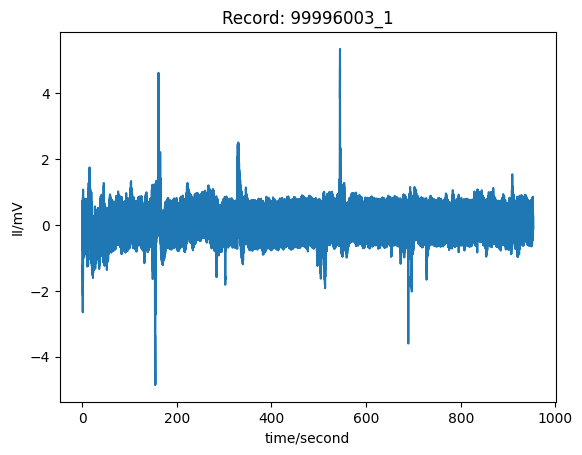

In [29]:
wfdb.plot_wfdb(record=record1)

In [30]:
record2 = records[1]
print(record2.__dict__)

{'record_name': '99996003_2', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 1636479, 'base_time': datetime.time(12, 16, 33, 72000), 'base_date': datetime.date(2225, 3, 31), 'comments': [], 'sig_name': ['II'], 'p_signal': array([[-0.13973566],
       [-0.12085246],
       [-0.0868627 ],
       ...,
       [ 0.33989754],
       [ 0.22659836],
       [ 0.17372541]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['99996003_2.dat'], 'fmt': ['212'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [264.78567552902877], 'baseline': [393], 'units': ['mV'], 'adc_res': [12], 'adc_zero': [0], 'init_value': [356], 'checksum': [27762], 'block_size': [0]}


In [79]:
get_start_end_times(record2)

Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


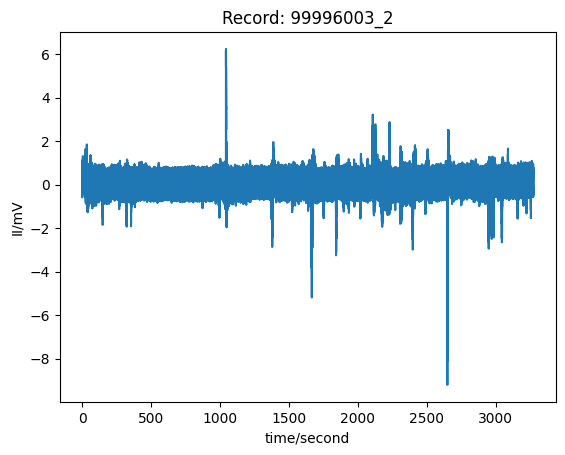

In [32]:
wfdb.plot_wfdb(record=record2)

In [73]:
alarms_df[alarms_df['CSN'] == Full_CSN]

,CSN,Alarm
440,99996003,2225-03-31 12:08:57


In [101]:
alarms_df['CSN'].shape

(425,)

In [100]:
alarms_df['CSN'].unique().shape

(425,)

In [76]:
alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm']

440   2225-03-31 12:08:57
Name: Alarm, dtype: datetime64[us]

In [86]:
for record in records:
    get_start_end_times(record)
    print("\n")

Date: 2225-03-31
Start time: 12:00:13.772000
End time: 12:16:06.766000


Date: 2225-03-31
Start time: 12:16:33.072000
End time: 13:11:06.030000


Date: 2225-03-31
Start time: 13:36:23.572000
End time: 16:44:12.792000




### cut off time up to 1 min before the alarm/ cardiac arrest

In [109]:
record = records[0]

record.__dict__

{'record_name': '99996003_1',
 'n_sig': 1,
 'fs': 500,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 476497,
 'base_time': datetime.time(12, 0, 13, 772000),
 'base_date': datetime.date(2225, 3, 31),
 'comments': [],
 'sig_name': ['II'],
 'p_signal': array([[-0.024923  ],
        [-0.0199384 ],
        [-0.0099692 ],
        ...,
        [ 0.0348922 ],
        [ 0.23427618],
        [ 0.33396817]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['99996003_1.dat'],
 'fmt': ['212'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [None],
 'adc_gain': [401.23583934088566],
 'baseline': [-99],
 'units': ['mV'],
 'adc_res': [12],
 'adc_zero': [0],
 'init_value': [-109],
 'checksum': [17044],
 'block_size': [0]}

In [152]:
alarm_ts = alarms_df[alarms_df['CSN'] == Full_CSN]['Alarm'].iloc[0]
measurements = get_measurements(record1, alarm_ts, cutoff_minutes = 1)
print(measurements[:5])
print("Sanity check for last entry: ", measurements[-1])

['12:00:13.772000, -0.024923', '12:00:13.774000, -0.019938', '12:00:13.776000, -0.009969', '12:00:13.778000, -0.009969', '12:00:13.780000, -0.019938']
Sanity check for last entry:  12:07:57, -0.044861


In [ ]:
# Each entry consists of a timestamp and the corresponding measurement value at that timestamp.


In [292]:
def get_measurements(record, alarm_ts=None, cutoff_minutes=1, new_fs=50):
    """
    new_fs: the downsampled number of samples taken per second (i.e. Hz)
    """
    signal = record.p_signal[:, 0]  # 1D array of measurements 
    start_time = datetime.combine(record.base_date, record.base_time)

    formatted = []

    # Determine cutoff time in seconds since start
    if alarm_ts is None:
        end_time = start_time + timedelta(seconds=record.sig_len / record.fs)
        cutoff_time = end_time - timedelta(minutes=cutoff_minutes)
    else:
        cutoff_time = alarm_ts - timedelta(minutes=cutoff_minutes)
    total_duration = (cutoff_time - start_time).total_seconds()
    max_idx = min(len(signal), int(total_duration * record.fs))

    step_sz = int(record.fs // new_fs)

    for i in range(0, max_idx, step_sz):
        current_time = start_time + timedelta(seconds=i / record.fs)
        # formatted.append(f"{current_time.time()}, {signal[i]:.6f}")
        formatted.append(signal[i])
    return np.array(formatted), start_time, cutoff_time, new_fs
